In [1]:
from __future__ import unicode_literals
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pickle

In [2]:
MODEL_1 = "finetuned"
MODEL_2 = "irishman"

SET_1_CALCULATED_METRICS_PATH = "data/evaluation/results/{}_vs_{}/{}_calculated_metrics.pkl".format(MODEL_1, MODEL_2, MODEL_1)
SET_2_CALCULATED_METRICS_PATH = "data/evaluation/results/{}_vs_{}/{}_calculated_metrics.pkl".format(MODEL_1, MODEL_2, MODEL_2)

ABSOLUTE_METRICS_STATISTICS_PATH = "data/evaluation/results/{}_vs_{}/absolute_metrics_statistics.pkl".format(MODEL_1, MODEL_2)
RELATIVE_METRICS_STATISTICS_PATH = "data/evaluation/results/{}_vs_{}/relative_metrics_statistics.pkl".format(MODEL_1, MODEL_2)

## Results finetuned vs irishman

Load calculated metrics for each model

In [3]:
with open(SET_1_CALCULATED_METRICS_PATH, "rb") as f:
    set1_loaded_results = pickle.load(f)

with open(SET_2_CALCULATED_METRICS_PATH, "rb") as f:
    set2_loaded_results = pickle.load(f)

display("Set 1 ({}): {} samples".format(MODEL_1, len(set1_loaded_results)))
display("Set 2 ({}): {} samples".format(MODEL_2, len(set2_loaded_results)))

u'Set 1 (finetuned): 9 samples'

u'Set 2 (irishman): 9 samples'

We calculated the following metrics:

**Pitch-based features**
- total_used_pitch
- total_pitch_class_histogram
- pitch_class_transition_matrix
- pitch_range
- avg_pitch_shift

**Rhythm-based features**
- total_used_note
- avg_IOI
- note_length_hist
- note_length_transition_matrix

In [4]:
display(set1_loaded_results.keys())

['total_used_note',
 'note_length_transition_matrix',
 'total_pitch_class_histogram',
 'total_used_pitch',
 'avg_IOI',
 'avg_pitch_shift',
 'pitch_range',
 'pitch_class_transition_matrix',
 'note_length_hist']

# Pitch-based features

## Feature: `total_used_pitch`

### O que faz:
Esta função conta quantas alturas (pitches) diferentes foram utilizadas em uma música MIDI, medindo a diversidade melódica.

### Como funciona (passo a passo):
1. `piano_roll = feature['pretty_midi'].instruments[0].get_piano_roll(fs=100)`
    - Converte o MIDI em uma matriz piano roll (128 x tempo)
    - 128 linhas = todas as notas possíveis (C0 até G9)
    - Cada coluna = um momento no tempo (100 fps)
    - Valores > 0 = nota está sendo tocada
    
2. `sum_notes = np.sum(piano_roll, axis=1)`
    - Soma cada linha (pitch) ao longo do tempo
    - Resultado: vetor de 128 elementos
    - Cada elemento = tempo total que aquela nota foi tocada

3. `used_pitch = np.sum(sum_notes > 0)`
    - Conta quantas notas tiveram sum > 0
    - Ou seja: quantas alturas diferentes foram usadas na música

### Exemplo prático:
```
Se uma música usa as notas: C4, D4, C4, E4, D4, C4, E3

piano_roll teria valores > 0 apenas nas linhas 52, 60, 62, 64 (MIDI numbers)

sum_notes[52] = tempo total de E3
sum_notes[60] = tempo total de C4
sum_notes[62] = tempo total de D4  
sum_notes[64] = tempo total de E4
sum_notes[outros] = 0

Resultado: total_used_pitch = 4 (quatro alturas diferentes)
```

### Ponto importante:
A função conta alturas únicas, não repetições:

- **C4 repetido 3x** = conta como 1 altura única
- **D4 repetido 2x** = conta como 1 altura única
- **E4 usado 1x** = conta como 1 altura única
- **E3 usado 1x** = conta como 1 altura única

**Total = 4 alturas diferentes**

### Diferença importante:
**total_used_pitch**: Quantas alturas diferentes (foco melódico)
**total_used_note**: Quantos eventos de nota (foco rítmico)
**total_pitch_class_histogram**: Proporção de cada classe (C, C#, D...)

### Interpretação musical:
- **Valores baixos (5-15)**: Melodias simples, poucas notas diferentes
- **Valores médios (20-40)**: Melodias moderadamente complexas
- **Valores altos (50+)**: Melodias muito diversas, muitas alturas diferentes

Esta métrica é útil para comparar a riqueza melódica entre os modelos.

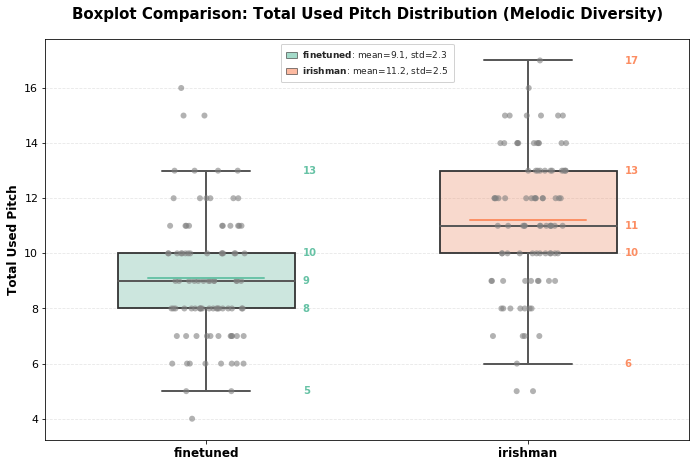

In [5]:
# Dados para total_used_pitch
data1_pitch = set1_loaded_results['total_used_pitch'].flatten()
data2_pitch = set2_loaded_results['total_used_pitch'].flatten()

# Figura e estilo
fig, ax = plt.subplots(figsize=(10, 7))
sns.set_style('whitegrid')

# Cores e rótulos
colors = ['#66c2a5', '#fc8d62']
labels = [MODEL_1, MODEL_2]
order = labels
pos_map = {lbl: i for i, lbl in enumerate(order)}

# Dados em formato long
df_pitch = pd.DataFrame({
    'value': np.concatenate([data1_pitch, data2_pitch]),
    'model': np.array([labels[0]] * len(data1_pitch) + [labels[1]] * len(data2_pitch))
})

# Boxplot (sem outliers)
sns.boxplot(x='model', y='value', data=df_pitch, ax=ax, palette=colors,
            width=0.55, showfliers=False, linewidth=2, saturation=0.8,
            order=order)

for artist in ax.artists:
    fc = artist.get_facecolor()
    artist.set_facecolor((fc[0], fc[1], fc[2], 0.35))  # mais transparente
    artist.set_edgecolor('#333333')
    artist.set_linewidth(1.8)

# Pontos (stripplot) com maior visibilidade - em cinza
for lbl, c in zip(labels, colors):
    sns.stripplot(x='model', y='value', data=df_pitch[df_pitch['model'] == lbl], ax=ax,
                  color='gray', size=6.0, jitter=0.12, alpha=0.6, linewidth=0,
                  order=order, zorder=4)

# Linha da média com a cor do box (acima dos pontos)
means_pitch = df_pitch.groupby('model')['value'].mean()
for lbl, c in zip(labels, colors):
    x = pos_map[lbl]
    m = float(means_pitch[lbl])
    ax.plot([x - 0.18, x + 0.18], [m, m], color=c, linewidth=2, alpha=0.95, zorder=5)

# Quartis e limites (whiskers) 1.5*IQR
qstats_pitch = df_pitch.groupby('model')['value'].quantile([0.25, 0.5, 0.75]).unstack()
for lbl, c in zip(labels, colors):
    vals = df_pitch.loc[df_pitch['model'] == lbl, 'value'].values
    q1 = float(qstats_pitch.loc[lbl, 0.25])
    med = float(qstats_pitch.loc[lbl, 0.50])
    q3 = float(qstats_pitch.loc[lbl, 0.75])
    iqr = q3 - q1
    lower_fence = q1 - 1.5 * iqr
    upper_fence = q3 + 1.5 * iqr
    # whiskers conforme definição do boxplot
    lw = float(np.min(vals[vals >= lower_fence])) if np.any(vals >= lower_fence) else float(np.min(vals))
    uw = float(np.max(vals[vals <= upper_fence])) if np.any(vals <= upper_fence) else float(np.max(vals))

    # Anotações numéricas à direita, mais afastadas do box
    x = pos_map[lbl] + 0.30
    ax.text(x, uw, '{:.0f}'.format(uw), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)
    ax.text(x, q3, '{:.0f}'.format(q3), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)
    ax.text(x, med, '{:.0f}'.format(med), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)
    ax.text(x, q1, '{:.0f}'.format(q1), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)
    ax.text(x, lw, '{:.0f}'.format(lw), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)

# Legenda centralizada no topo em 2 linhas
stds_pitch = df_pitch.groupby('model')['value'].std()
# Deixa os nomes dos modelos em negrito na legenda (mathtext \mathbf{})
bold = lambda s: '$\\mathbf{%s}$' % s
label_stats_pitch = [
    '{}: mean={:.1f}, std={:.1f}'.format(bold(labels[0]), float(means_pitch[labels[0]]), float(stds_pitch[labels[0]])),
    '{}: mean={:.1f}, std={:.1f}'.format(bold(labels[1]), float(means_pitch[labels[1]]), float(stds_pitch[labels[1]]))
]
handles_pitch = [Patch(facecolor=colors[0], edgecolor='#333333', alpha=0.6),
                 Patch(facecolor=colors[1], edgecolor='#333333', alpha=0.6)]
ax.legend(handles_pitch, label_stats_pitch, loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=1,
          frameon=True, framealpha=0.88, borderpad=0.6, fontsize=9,
          handlelength=1.2, handletextpad=0.6, labelspacing=0.45)

# Margens X simétricas ao redor dos dois boxes
ax.set_xlim(-0.5, len(labels) - 0.5)

# Rótulos
ax.set_xlabel('')
ax.set_ylabel('Total Used Pitch', fontsize=12, weight='bold')
ax.set_title('Boxplot Comparison: Total Used Pitch Distribution (Melodic Diversity)', fontsize=15, weight='bold', pad=20)
ax.tick_params(axis='both', which='major', labelsize=11)

for tick in ax.get_xticklabels():
    tick.set_fontsize(12)
    tick.set_fontweight('bold')

ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

plt.tight_layout()
fig.subplots_adjust(bottom=0.12)
plt.show()

# Feature: `total_pitch_class_histogram`

## Visão Geral

A função `total_pitch_class_histogram` (linha 169) calcula um **histograma de classes de altura** (pitch class histogram) para um arquivo MIDI. Esta função cria uma representação independente de oitava do conteúdo harmônico da música.

## Propósito

Quantifica a frequência de uso de cada uma das 12 notas da escala cromática:
- **0**: Dó
- **1**: Dó#/Réb  
- **2**: Ré
- **3**: Ré#/Mib
- **4**: Mi
- **5**: Fá
- **6**: Fá#/Solb
- **7**: Sol
- **8**: Sol#/Láb
- **9**: Lá
- **10**: Lá#/Sib
- **11**: Si

## Parâmetros

- **`feature`**: Dicionário contendo um objeto `pretty_midi`

## Retorno

Array NumPy de 12 elementos representando a proporção de tempo que cada classe de altura foi utilizada na música (normalizado para somar 1).

## Como Funciona

### 1. Conversão para Piano Roll
```python
piano_roll = feature['pretty_midi'].instruments[0].get_piano_roll(fs=100)
```
- Converte o MIDI em representação "piano roll" com frequência de amostragem de 100Hz
- Matriz onde cada linha representa uma nota MIDI (0-127) e cada coluna um momento no tempo

### 2. Inicialização do Histograma
```python
histogram = np.zeros(12)
```
- Cria array de 12 posições (uma para cada classe de altura)

### 3. Cálculo das Classes de Altura
```python
for i in range(0, 128):
    pitch_class = i % 12
    histogram[pitch_class] += np.sum(piano_roll, axis=1)[i]
```
- Para cada nota MIDI (0-127), calcula sua classe de altura usando módulo 12
- **Exemplo**: 
  - Nota 60 (Dó central) → `60 % 12 = 0`
  - Nota 72 (Dó uma oitava acima) → `72 % 12 = 0`
- Soma a duração total dessa nota ao longo de toda a música
- Acumula no histograma da classe de altura correspondente

### 4. Normalização
```python
histogram = histogram / sum(histogram)
```
- Normaliza o histograma para criar uma distribuição de probabilidade (soma = 1)

## Aplicações

Esta métrica é útil para:
- **Análise harmônica**: Identificar quais notas são mais predominantes
- **Identificação de tonalidade**: Padrões podem indicar a tonalidade da música
- **Comparação musical**: Comparar o conteúdo harmônico entre diferentes peças
- **Classificação de gêneros**: Diferentes gêneros podem ter padrões característicos

## Exemplo de Interpretação

Se o histograma retornar `[0.3, 0.0, 0.2, 0.0, 0.25, 0.15, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0]`:
- **30%** do tempo usa Dó (classe 0)
- **20%** do tempo usa Ré (classe 2)  
- **25%** do tempo usa Mi (classe 4)
- **15%** do tempo usa Fá (classe 5)
- **10%** do tempo usa Sol (classe 7)
- Outras notas não são utilizadas

Isso sugere uma música em Dó Maior, usando principalmente as notas da tríade de Dó (Dó-Mi-Sol) com Ré e Fá como notas auxiliares.

In [6]:
# Preparar dados do pitch class histogram
pitch_hist_1 = set1_loaded_results['total_pitch_class_histogram']
pitch_hist_2 = set2_loaded_results['total_pitch_class_histogram']

# Labels das notas musicais
note_labels = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

print("Shape do {}: {}".format(MODEL_1, pitch_hist_1.shape))
print("Shape do {}: {}".format(MODEL_2, pitch_hist_2.shape))
print("Primeiro exemplo {}: {}".format(MODEL_1, pitch_hist_1[0]))
print("Soma do primeiro exemplo {}: {}".format(MODEL_1, np.sum(pitch_hist_1[0])))

Shape do finetuned: (93, 12)
Shape do irishman: (93, 12)
Primeiro exemplo finetuned: [0.         0.05208333 0.35416667 0.         0.0625     0.
 0.125      0.         0.         0.21875    0.         0.1875    ]
Soma do primeiro exemplo finetuned: 1.0


#### 1. Gráfico de Barras Agrupadas - Comparação Direta

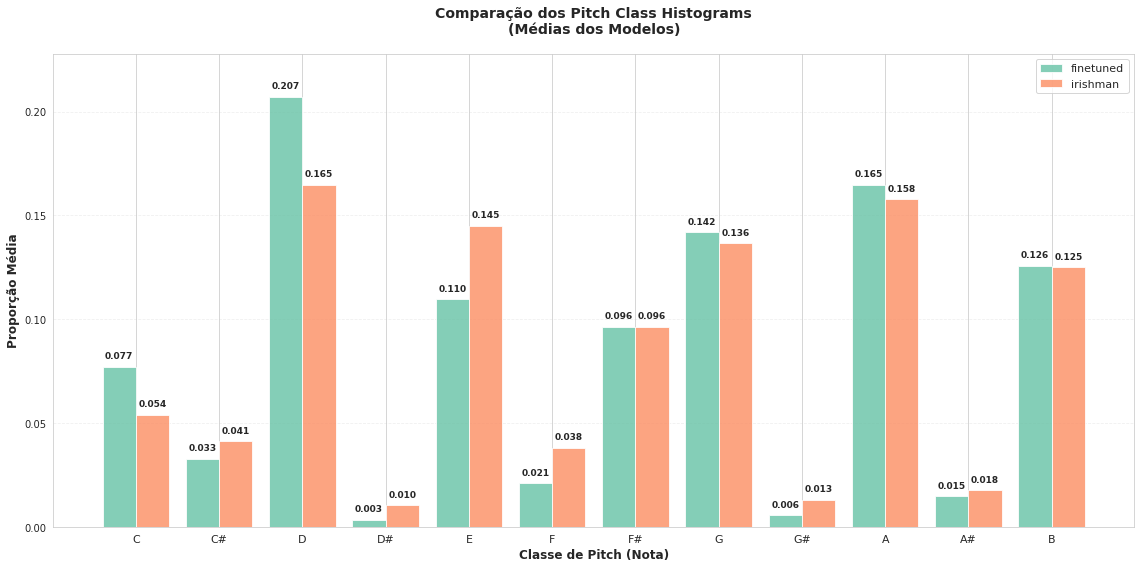

In [7]:
# Criar gráfico de barras agrupadas
fig, ax = plt.subplots(figsize=(16, 8))

x = np.arange(len(note_labels))
width = 0.4

# Calcular médias para cada modelo
mean_hist_1 = np.mean(pitch_hist_1, axis=0)
mean_hist_2 = np.mean(pitch_hist_2, axis=0)

# Barras
bars1 = ax.bar(x - width/2, mean_hist_1, width, 
               label=MODEL_1, color='#66c2a5', alpha=0.8)
bars2 = ax.bar(x + width/2, mean_hist_2, width,
               label=MODEL_2, color='#fc8d62', alpha=0.8)

# Customização
ax.set_xlabel('Classe de Pitch (Nota)', fontsize=12, weight='bold')
ax.set_ylabel('Proporção Média', fontsize=12, weight='bold')
ax.set_title('Comparação dos Pitch Class Histograms\n(Médias dos Modelos)', 
             fontsize=14, weight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(note_labels, fontsize=11)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Adicionar valores nas barras
for i, (bar1, bar2, val1, val2) in enumerate(zip(bars1, bars2, mean_hist_1, mean_hist_2)):
    if val1 > 0.001:  # Mostrar valores acima de 0.1%
        ax.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + 0.003,
                '{:.3f}'.format(val1), ha='center', va='bottom', fontsize=9, weight='bold')
    if val2 > 0.001:  # Mostrar valores acima de 0.1%
        ax.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height() + 0.003,
                '{:.3f}'.format(val2), ha='center', va='bottom', fontsize=9, weight='bold')

# Ajustar limite superior do eixo Y para acomodar os valores nas barras
max_height = max(np.max(mean_hist_1), np.max(mean_hist_2))
ax.set_ylim(0, max_height * 1.10)  # 10% de margem superior

plt.tight_layout()
plt.show()

#### 2. Visualização Consolidada - Radar Chart Comparativo

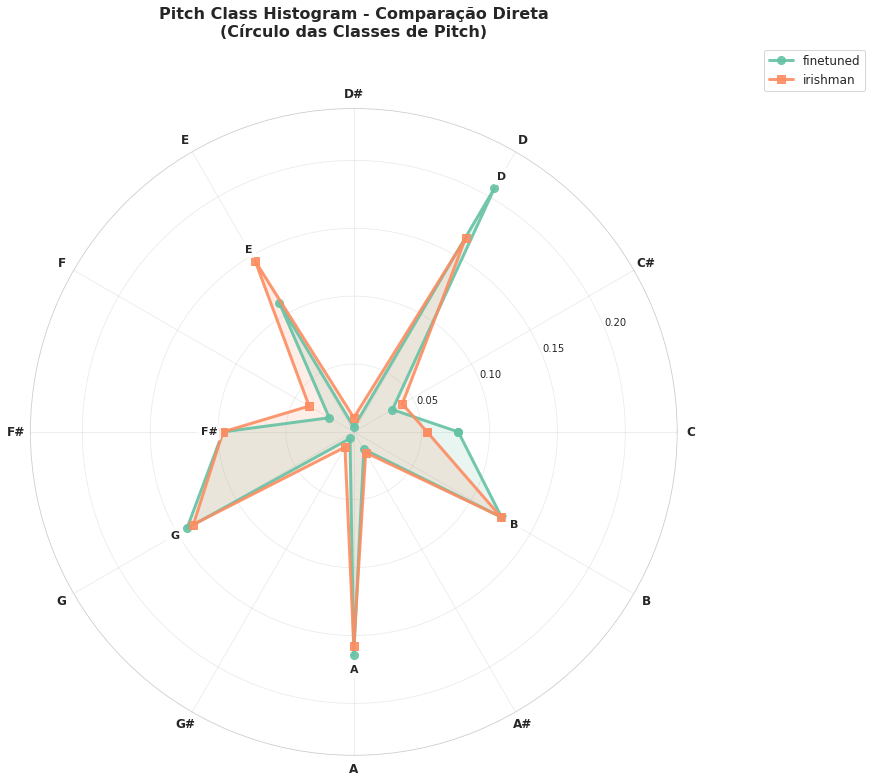

In [8]:
# Gráfico radar/spider final - comparação direta dos dois modelos
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(projection='polar'))

# Ângulos para as 12 notas (melhor organização visual)
angles = np.linspace(0, 2 * np.pi, 12, endpoint=False)

# Fechar o polígono (repetir primeiro valor no final)
angles_closed = np.concatenate([angles, [angles[0]]])
values_1_closed = np.concatenate([mean_hist_1, [mean_hist_1[0]]])
values_2_closed = np.concatenate([mean_hist_2, [mean_hist_2[0]]])

# Plot dos dois modelos
ax.plot(angles_closed, values_1_closed, 'o-', linewidth=3, 
        label=MODEL_1, color='#66c2a5', markersize=8, alpha=0.9)
ax.fill(angles_closed, values_1_closed, alpha=0.15, color='#66c2a5')

ax.plot(angles_closed, values_2_closed, 's-', linewidth=3, 
        label=MODEL_2, color='#fc8d62', markersize=8, alpha=0.9)
ax.fill(angles_closed, values_2_closed, alpha=0.15, color='#fc8d62')

# Customização
ax.set_xticks(angles)
ax.set_xticklabels(note_labels, fontsize=12, weight='bold')
ax.set_title('Pitch Class Histogram - Comparação Direta\n(Círculo das Classes de Pitch)', 
             fontsize=16, weight='bold', pad=40)
ax.grid(True, alpha=0.4)
ax.set_ylim(0, max(np.max(mean_hist_1), np.max(mean_hist_2)) * 1.15)

# Legenda
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=12)

# Adicionar valores nos pontos principais (apenas os maiores valores)
max_indices = np.argsort(mean_hist_1 + mean_hist_2)[-6:]  # top 6
for i in max_indices:
    angle = angles[i]
    val1, val2 = mean_hist_1[i], mean_hist_2[i]
    max_val = max(val1, val2)
    
    # Texto do lado externo do círculo
    radius_text = max_val + max(np.max(mean_hist_1), np.max(mean_hist_2)) * 0.05
    ax.text(angle, radius_text, '{}'.format(note_labels[i]), 
           ha='center', va='center', fontsize=11, weight='bold',
           bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Feature: `pitch_class_transition_matrix`

## Visão Geral

A função `pitch_class_transition_matrix` é uma ferramenta de análise musical que calcula uma **matriz de transição de classes de altura** (pitch class transition matrix). Esta função está localizada na linha 243 do arquivo `core.py` e é fundamental para análise de padrões harmônicos e melódicos em dados MIDI.

## Definição

Uma matriz de transição de classes de altura é uma representação bidimensional semelhante a um histograma que conta as transições de altura para cada par ordenado de notas. As classes de altura representam as 12 notas musicais cromáticas (C, C#, D, D#, E, F, F#, G, G#, A, A#, B), independentemente da oitava em que são tocadas.

## Assinatura da Função

```python
def pitch_class_transition_matrix(self, feature, normalize=0):
```

### Parâmetros

- **`feature`**: Dicionário contendo dados musicais com um objeto `pretty_midi`
- **`normalize`**: Parâmetro de normalização (padrão: 0)
  - `0`: Retorna a matriz sem normalização (contagens absolutas)
  - `1`: Normaliza por linha (cada linha soma 1)
  - `2`: Normaliza pela soma total da matriz (toda matriz soma 1)

### Retorno

- **`transition_matrix`**: Matriz numpy de forma [12, 12] representando as transições entre classes de altura

## Como Funciona

1. **Extração dos dados**: A função obtém o objeto `pretty_midi` dos dados de entrada
2. **Cálculo da matriz**: Chama o método `get_pitch_class_transition_matrix()` que:
   - Analisa sequencialmente as notas na música
   - Conta quantas vezes cada classe de altura é seguida por outra
   - Constrói uma matriz 12×12 onde `matriz[i][j]` = número de vezes que a nota `i` foi seguida pela nota `j`
3. **Normalização**: Aplica o tipo de normalização especificado

## Tipos de Normalização

### Sem Normalização (normalize=0)
```python
return transition_matrix
```
Retorna as contagens brutas das transições.

### Normalização por Linha (normalize=1)
```python
sums = np.sum(transition_matrix, axis=1)
sums[sums == 0] = 1
return transition_matrix / sums.reshape(-1, 1)
```
Cada linha da matriz soma 1, representando probabilidades condicionais de transição a partir de cada nota.

### Normalização Global (normalize=2)
```python
return transition_matrix / sum(sum(transition_matrix))
```
Toda a matriz soma 1, representando a distribuição de probabilidade conjunta das transições.

## Aplicações Musicais

### 1. Detecção de Tonalidade
Diferentes tonalidades produzem padrões característicos de transição. Por exemplo:
- **Dó Maior**: Mais transições entre C-D, D-E, E-F, F-G, G-A, A-B, B-C
- **Dó menor**: Padrões diferentes envolvendo E♭, A♭, B♭

### 2. Reconhecimento de Acordes
Progressões harmônicas comuns criam assinaturas específicas:
- **I-V-vi-IV**: Produz padrões de transição característicos
- **ii-V-I**: Gera sequências previsíveis na matriz

### 3. Análise de Gênero Musical
Diferentes estilos musicais apresentam padrões distintos:
- **Jazz**: Transições cromáticas mais frequentes
- **Folk/Pop**: Transições diatônicas predominantes
- **Música atonal**: Distribuição mais uniforme

## Exemplo Prático

Para uma melodia simples em Dó Maior: `C-D-E-F-G-A-B-C`

A matriz de transição teria valores não-zero nas posições:
- `[0,2]`: C→D (1 transição)
- `[2,4]`: D→E (1 transição)  
- `[4,5]`: E→F (1 transição)
- `[5,7]`: F→G (1 transição)
- `[7,9]`: G→A (1 transição)
- `[9,11]`: A→B (1 transição)
- `[11,0]`: B→C (1 transição)

## Interpretação dos Resultados

### Matriz Normalizada por Linha
- Cada elemento `[i,j]` representa: "Dado que acabei de tocar a nota `i`, qual a probabilidade de tocar a nota `j` em seguida?"
- Útil para análise de padrões melódicos e harmônicos

### Matriz Normalizada Globalmente  
- Cada elemento representa a frequência relativa de cada tipo de transição no contexto da peça inteira
- Útil para comparação entre diferentes peças musicais

## Considerações Técnicas

- A matriz sempre terá dimensões 12×12, correspondendo às 12 classes de altura cromáticas
- Valores na diagonal principal representam repetições da mesma nota
- A soma das linhas na normalização por linha sempre será 1 (exceto para linhas totalmente vazias)
- A função trata casos especiais onde não há transições a partir de certas notas

## Limitações

1. **Perda de informação temporal**: A matriz não preserva informação sobre timing ou duração
2. **Redução de oitavas**: Todas as notas são reduzidas às suas classes de altura (C1, C4, C7 → C)
3. **Contexto harmônico**: Não distingue entre diferentes contextos harmônicos da mesma transição

Esta ferramenta é essencial para análise computacional de música, fornecendo uma representação compacta e matematicamente tratável dos padrões de altura em composições musicais.

In [9]:
# Explorar os dados da pitch_class_transition_matrix
transition_1 = set1_loaded_results['pitch_class_transition_matrix']
transition_2 = set2_loaded_results['pitch_class_transition_matrix']

print("Shape do {}: {}".format(MODEL_1, transition_1.shape))
print("Shape do {}: {}".format(MODEL_2, transition_2.shape))
print("\nPrimeiro exemplo {} (original):".format(MODEL_1))
print(transition_1[0])
print("Soma da primeira matriz {}: {:.4f}".format(MODEL_1, np.sum(transition_1[0])))

print("\nPrimeiro exemplo {} (original):".format(MODEL_2))
print(transition_2[0])
print("Soma da primeira matriz {}: {:.4f}".format(MODEL_2, np.sum(transition_2[0])))

# Verificar se há valores significativos
print("\nEstatísticas básicas:")
print("{} - valores não-zero: {:.1f}%, máximo: {:.4f}".format(
    MODEL_1, np.mean(transition_1 > 0) * 100, np.max(transition_1)))
print("{} - valores não-zero: {:.1f}%, máximo: {:.4f}".format(
    MODEL_2, np.mean(transition_2 > 0) * 100, np.max(transition_2)))

Shape do finetuned: (93, 12, 12)
Shape do irishman: (93, 12, 12)

Primeiro exemplo finetuned (original):
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 8. 0. 0. 0. 1. 0. 0. 3. 0. 8.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 3. 0. 6. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 5. 0. 0. 0. 2. 0. 0. 6. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 5. 0. 0. 0. 0. 0. 0. 0. 3. 0. 5.]]
Soma da primeira matriz finetuned: 63.0000

Primeiro exemplo irishman (original):
[[ 0.  0.  0.  0. 10.  0.  0.  0.  0. 14.  0. 12.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  6.  0. 10.  0.  0.  4.  0.  0.  0. 20.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [10.  0. 16.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  6.  0.  0. 28.  0. 

In [10]:
# Preparar dados para visualização
from matplotlib.gridspec import GridSpec

# Calcular matrizes médias normalizadas por linha (probabilidades de transição)
def normalize_transition_matrix(matrix):
    """Normaliza matriz de transição por linha (probabilidades condicionais)"""
    normalized = matrix.copy()
    row_sums = np.sum(matrix, axis=2, keepdims=True)
    row_sums[row_sums == 0] = 1  # Evitar divisão por zero
    normalized = matrix / row_sums
    return normalized

# Normalizar todas as matrizes
transition_1_norm = normalize_transition_matrix(transition_1)
transition_2_norm = normalize_transition_matrix(transition_2)

# Calcular médias
mean_transition_1 = np.mean(transition_1_norm, axis=0)
mean_transition_2 = np.mean(transition_2_norm, axis=0)

# Calcular diferença (Model1 - Model2)
diff_matrix = mean_transition_1 - mean_transition_2

# Labels das notas
note_labels = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

print("Preparação concluída!")
print("Matriz média {} - valores não-zero: {:.1f}%".format(
    MODEL_1, np.mean(mean_transition_1 > 0.001) * 100))
print("Matriz média {} - valores não-zero: {:.1f}%".format(
    MODEL_2, np.mean(mean_transition_2 > 0.001) * 100))

Preparação concluída!
Matriz média finetuned - valores não-zero: 78.5%
Matriz média irishman - valores não-zero: 88.2%


#### 1. Heatmaps Comparativos - Matrizes de Transição Médias

Os heatmaps mostram as **probabilidades de transição condicionais**: dado que tocamos a nota da linha, qual a probabilidade de tocar a nota da coluna em seguida.

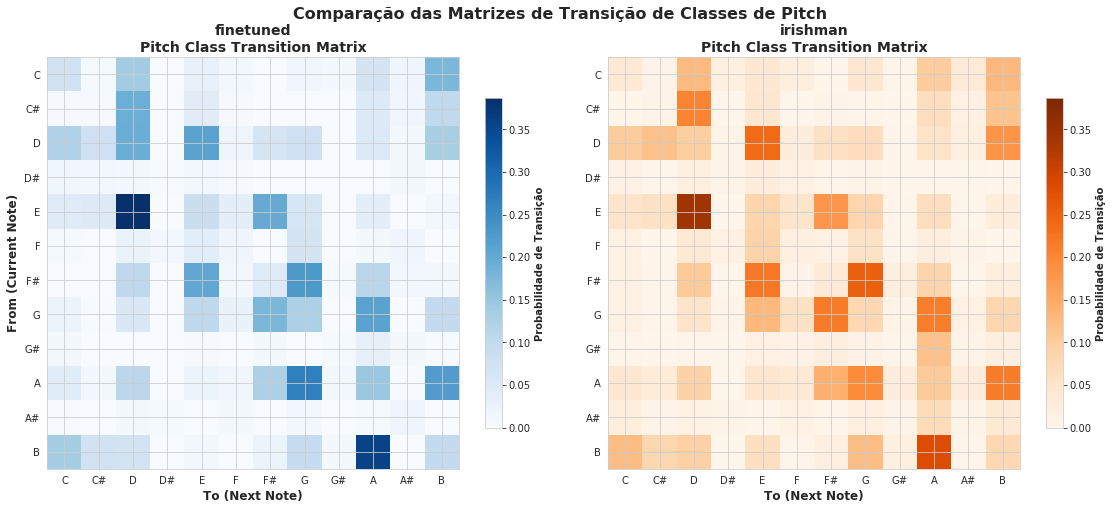

In [11]:
# 1. Heatmaps comparativos das matrizes de transição
fig = plt.figure(figsize=(16, 7))  # Aumentei a altura da figura
gs = GridSpec(1, 2, width_ratios=[1, 1], figure=fig)

# Definir escala comum para comparação
vmax = max(np.max(mean_transition_1), np.max(mean_transition_2))
vmin = 0

# Subplot 1: Model 1
ax1 = fig.add_subplot(gs[0])
im1 = ax1.imshow(mean_transition_1, cmap='Blues', aspect='equal', 
                 vmin=vmin, vmax=vmax, interpolation='nearest')
ax1.set_title('{}\nPitch Class Transition Matrix'.format(MODEL_1), fontsize=14, weight='bold')
ax1.set_xlabel('To (Next Note)', fontsize=12, weight='bold')
ax1.set_ylabel('From (Current Note)', fontsize=12, weight='bold')
ax1.set_xticks(range(12))
ax1.set_yticks(range(12))
ax1.set_xticklabels(note_labels, fontsize=10)
ax1.set_yticklabels(note_labels, fontsize=10)

# Subplot 2: Model 2
ax2 = fig.add_subplot(gs[1])
im2 = ax2.imshow(mean_transition_2, cmap='Oranges', aspect='equal', 
                 vmin=vmin, vmax=vmax, interpolation='nearest')
ax2.set_title('{}\nPitch Class Transition Matrix'.format(MODEL_2), fontsize=14, weight='bold')
ax2.set_xlabel('To (Next Note)', fontsize=12, weight='bold')
ax2.set_ylabel('')
ax2.set_xticks(range(12))
ax2.set_yticks(range(12))
ax2.set_xticklabels(note_labels, fontsize=10)
ax2.set_yticklabels(note_labels, fontsize=10)

# Colorbars
cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8)
cbar1.set_label('Probabilidade de Transição', fontsize=10, weight='bold')
cbar2 = plt.colorbar(im2, ax=ax2, shrink=0.8)
cbar2.set_label('Probabilidade de Transição', fontsize=10, weight='bold')

plt.suptitle('Comparação das Matrizes de Transição de Classes de Pitch', 
             fontsize=16, weight='bold', y=0.95)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

#### 2. Visualização em Rede das Transições Principais

Esta visualização mostra as transições como uma rede de conexões entre as notas, onde a espessura das setas representa a probabilidade de transição:

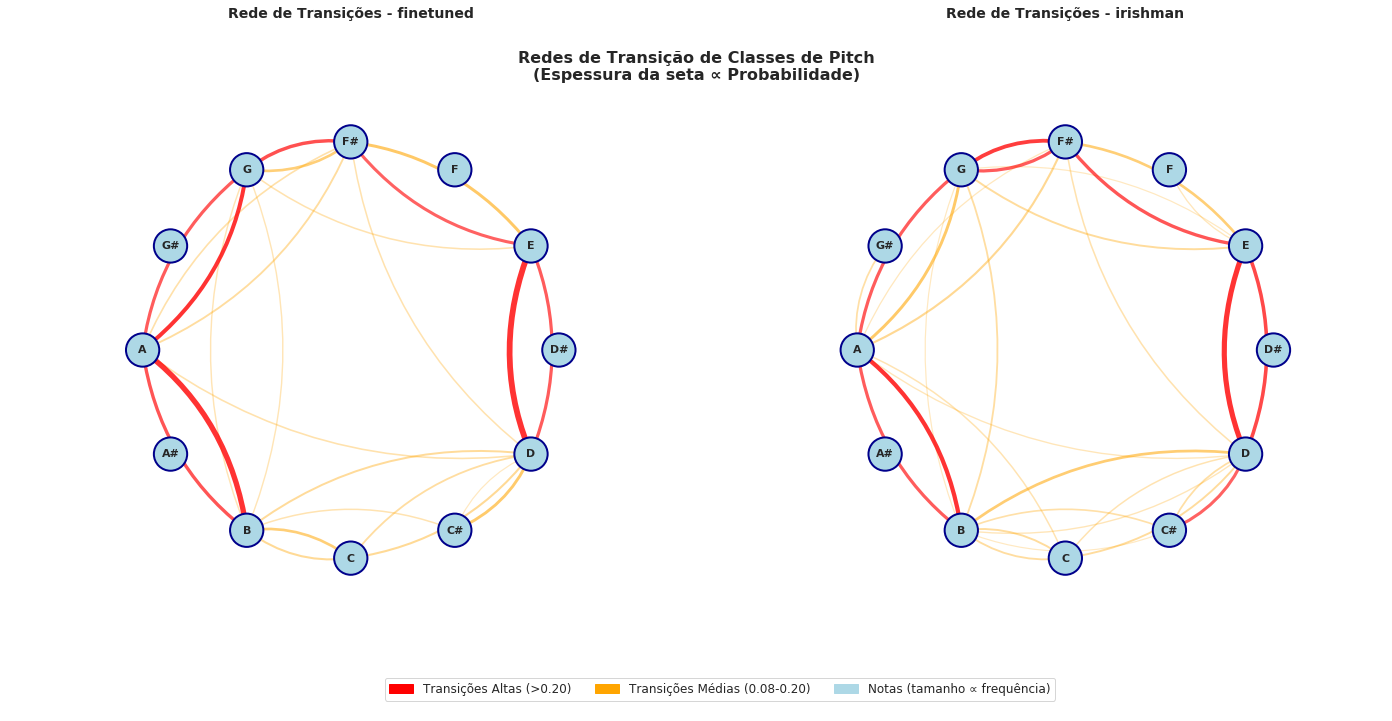

In [12]:
# 3. Visualização em rede das transições (círculo das quintas adaptado)
import matplotlib.patches as mpatches
from matplotlib.patches import FancyArrowPatch

def plot_transition_network(matrix, title, ax, threshold=0.08):
    """Plota rede de transições em layout circular"""
    
    # Posições das notas em círculo (ordem cromática)
    angles = np.linspace(0, 2*np.pi, 12, endpoint=False)
    angles = angles - np.pi/2  # Começar no topo (C)
    
    radius = 1.0
    positions = {}
    for i, note in enumerate(note_labels):
        x = radius * np.cos(angles[i])
        y = radius * np.sin(angles[i])
        positions[note] = (x, y)
    
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_aspect('equal')
    
    # Desenhar nós (notas)
    for note, (x, y) in positions.items():
        # Tamanho do nó baseado na frequência total de uso
        note_idx = note_labels.index(note)
        total_from = np.sum(matrix[note_idx, :])
        total_to = np.sum(matrix[:, note_idx])
        node_size = (total_from + total_to) * 1000 + 300
        
        circle = plt.Circle((x, y), 0.08, color='lightblue', 
                          ec='darkblue', linewidth=2, zorder=3)
        ax.add_patch(circle)
        ax.text(x, y, note, ha='center', va='center', 
                fontsize=11, weight='bold', zorder=4)
    
    # Desenhar arestas (transições acima do threshold)
    for i in range(12):
        for j in range(12):
            if matrix[i, j] > threshold and i != j:  # Não mostrar auto-loops
                from_note = note_labels[i]
                to_note = note_labels[j]
                
                x1, y1 = positions[from_note]
                x2, y2 = positions[to_note]
                
                # Calcular ponto de controle para curva
                mid_x = (x1 + x2) / 2
                mid_y = (y1 + y2) / 2
                
                # Distância do centro para criar curvatura
                center_dist = np.sqrt(mid_x**2 + mid_y**2)
                if center_dist > 0:
                    # Curvar para fora do círculo
                    curve_factor = 0.3
                    ctrl_x = mid_x + (mid_x/center_dist) * curve_factor
                    ctrl_y = mid_y + (mid_y/center_dist) * curve_factor
                else:
                    ctrl_x, ctrl_y = mid_x, mid_y
                
                # Espessura da linha proporcional à probabilidade
                line_width = matrix[i, j] * 15
                alpha = min(0.8, matrix[i, j] * 3)
                
                # Desenhar seta curvada
                arrow = mpatches.FancyArrowPatch(
                    (x1, y1), (x2, y2),
                    connectionstyle="arc3,rad=0.2",
                    arrowstyle='->', 
                    mutation_scale=15,
                    linewidth=line_width,
                    color='red' if matrix[i, j] > 0.2 else 'orange',
                    alpha=alpha,
                    zorder=2
                )
                ax.add_patch(arrow)
    
    ax.set_title(title, fontsize=14, weight='bold', pad=20)
    ax.axis('off')

# Criar figura com duas redes lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

plot_transition_network(mean_transition_1, 
                       'Rede de Transições - {}'.format(MODEL_1), 
                       ax1, threshold=0.08)

plot_transition_network(mean_transition_2, 
                       'Rede de Transições - {}'.format(MODEL_2), 
                       ax2, threshold=0.08)

# Legenda
legend_elements = [
    mpatches.Patch(color='red', label='Transições Altas (>0.20)'),
    mpatches.Patch(color='orange', label='Transições Médias (0.08-0.20)'),
    mpatches.Patch(color='lightblue', label='Notas (tamanho ∝ frequência)')
]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, 
          fontsize=12, bbox_to_anchor=(0.5, 0.02))

plt.suptitle('Redes de Transição de Classes de Pitch\n(Espessura da seta ∝ Probabilidade)', 
             fontsize=16, weight='bold', y=0.95)
plt.tight_layout()
plt.subplots_adjust(bottom=0.1)
plt.show()

In [13]:
# Sumário das principais diferenças entre os modelos

print("="*80)
print("SUMÁRIO: ANÁLISE DE TRANSIÇÕES DE CLASSES DE PITCH")
print("="*80)

# 1. Calcular diferenças absolutas entre as matrizes
diff_matrix = np.abs(mean_transition_1 - mean_transition_2)

# Encontrar as maiores diferenças
flat_diff = diff_matrix.flatten()
sorted_indices = np.argsort(flat_diff)[::-1]

print("\n1. MAIORES DIFERENÇAS ENTRE OS MODELOS (Top 10)")
print("-" * 60)
for i in range(10):
    idx = sorted_indices[i]
    from_note = idx // 12
    to_note = idx % 12
    diff = diff_matrix[from_note, to_note]
    prob1 = mean_transition_1[from_note, to_note]
    prob2 = mean_transition_2[from_note, to_note]
    
    print("{:>3} → {:<3}: {} = {:.3f} | {} = {:.3f} | Diff = {:.3f}".format(
        note_labels[from_note], note_labels[to_note], 
        MODEL_1, prob1, MODEL_2, prob2, diff))

# 2. Análise das notas mais utilizadas (diagonal principal)
print("\n2. REPETIÇÃO DE NOTAS (Diagonal Principal)")
print("-" * 60)
diag_1 = np.diag(mean_transition_1)
diag_2 = np.diag(mean_transition_2)

for i, note in enumerate(note_labels):
    print("{:>3}: {} = {:.3f} | {} = {:.3f} | Diff = {:.3f}".format(
        note, MODEL_1, diag_1[i], MODEL_2, diag_2[i], 
        abs(diag_1[i] - diag_2[i])))

# 3. Estatísticas gerais
entropy_1 = -np.sum(mean_transition_1 * np.log2(mean_transition_1 + 1e-10))
entropy_2 = -np.sum(mean_transition_2 * np.log2(mean_transition_2 + 1e-10))

print("\n3. ESTATÍSTICAS GERAIS")
print("-" * 60)
print("Entropia das transições:")
print("  {}: {:.3f}".format(MODEL_1, entropy_1))
print("  {}: {:.3f}".format(MODEL_2, entropy_2))
print("  Diferença: {:.3f}".format(abs(entropy_1 - entropy_2)))

# 4. Análise de intervalos musicais
intervals = {
    'Unísono': [0], 'Semitom': [1, 11], 'Tom': [2, 10], 
    'Terça menor': [3, 9], 'Terça maior': [4, 8], 'Quarta': [5, 7], 'Trítono': [6]
}

print("\n4. ANÁLISE POR INTERVALOS MUSICAIS")
print("-" * 60)
for interval_name, semitones in intervals.items():
    sum_1 = sum_2 = 0
    count = 0
    for i in range(12):
        for j in range(12):
            interval = (j - i) % 12
            if interval in semitones:
                sum_1 += mean_transition_1[i, j]
                sum_2 += mean_transition_2[i, j]
                count += 1
    
    avg_1 = sum_1 / count if count > 0 else 0
    avg_2 = sum_2 / count if count > 0 else 0
    print("{:>12}: {} = {:.3f} | {} = {:.3f} | Diff = {:.3f}".format(
        interval_name, MODEL_1, avg_1, MODEL_2, avg_2, 
        abs(avg_1 - avg_2)))

print("="*80)
print("CONCLUSÕES:")
print("- As diferenças mais significativas mostram padrões composicionais distintos")
print("- A análise de intervalos revela preferências harmônicas diferentes")
print("- As redes de transição visualizam as 'assinaturas' musicais de cada modelo")
print("="*80)

SUMÁRIO: ANÁLISE DE TRANSIÇÕES DE CLASSES DE PITCH

1. MAIORES DIFERENÇAS ENTRE OS MODELOS (Top 10)
------------------------------------------------------------
  D → D  : finetuned = 0.193 | irishman = 0.099 | Diff = 0.094
 G# → A  : finetuned = 0.030 | irishman = 0.116 | Diff = 0.086
  B → A  : finetuned = 0.356 | irishman = 0.282 | Diff = 0.074
  A → G  : finetuned = 0.266 | irishman = 0.196 | Diff = 0.071
 A# → A  : finetuned = 0.005 | irishman = 0.070 | Diff = 0.065
  B → E  : finetuned = 0.010 | irishman = 0.063 | Diff = 0.053
  D → B  : finetuned = 0.132 | irishman = 0.183 | Diff = 0.050
  G → G  : finetuned = 0.127 | irishman = 0.077 | Diff = 0.050
  C → B  : finetuned = 0.177 | irishman = 0.128 | Diff = 0.049
  F → E  : finetuned = 0.042 | irishman = 0.089 | Diff = 0.047

2. REPETIÇÃO DE NOTAS (Diagonal Principal)
------------------------------------------------------------
  C: finetuned = 0.075 | irishman = 0.037 | Diff = 0.038
 C#: finetuned = 0.004 | irishman = 0.007 | Dif

# Feature: `pitch_range`

## Visão Geral
A função `pitch_range` na linha 274 do arquivo `core.py` calcula o **alcance de pitch** (intervalo de altura das notas) de uma música. Esta métrica mede a extensão total das notas utilizadas em uma composição musical.

## Definição
O pitch range é calculado pela subtração entre a nota mais aguda (highest) e a mais grave (lowest) utilizadas na música, expresso em semitons.

## Implementação

```python
def pitch_range(self, feature):
    """
    pitch_range (Pitch range):
    The pitch range is calculated by subtraction of the highest and lowest used pitch in semitones.

    Returns:
    'p_range': a scalar for each sample.
    """
    piano_roll = feature['pretty_midi'].instruments[0].get_piano_roll(fs=100)
    pitch_index = np.where(np.sum(piano_roll, axis=1) > 0)
    p_range = np.max(pitch_index) - np.min(pitch_index)
    return p_range
```

## Como Funciona

### 1. Extração do Piano Roll
```python
piano_roll = feature['pretty_midi'].instruments[0].get_piano_roll(fs=100)
```
- **Objetivo**: Obtém uma representação matricial da música (piano roll)
- **Parâmetros**: 
  - `fs=100`: Frequência de amostragem de 100 Hz
  - `instruments[0]`: Utiliza o primeiro instrumento da composição
- **Resultado**: Matriz onde:
  - Cada linha representa uma nota MIDI (0-127)
  - Cada coluna representa um momento no tempo
  - Valores indicam a velocidade/intensidade da nota naquele momento

### 2. Identificação das Notas Utilizadas
```python
pitch_index = np.where(np.sum(piano_roll, axis=1) > 0)
```
- **Objetivo**: Identifica quais notas foram efetivamente tocadas na música
- **Processo**:
  - `np.sum(piano_roll, axis=1)`: Soma cada linha do piano roll (todas as ocorrências de cada nota)
  - `> 0`: Verifica se a nota foi tocada pelo menos uma vez
  - `np.where(...)`: Retorna os índices das notas que foram utilizadas

### 3. Cálculo do Alcance
```python
p_range = np.max(pitch_index) - np.min(pitch_index)
```
- **Objetivo**: Calcula a diferença entre a nota mais alta e mais baixa
- **Processo**:
  - `np.max(pitch_index)`: Encontra o índice MIDI da nota mais aguda
  - `np.min(pitch_index)`: Encontra o índice MIDI da nota mais grave
  - Subtração: Diferença em semitons entre ambas

## Retorno
A função retorna um valor escalar (`p_range`) que representa:
- **Unidade**: Semitons
- **Significado**: Extensão total de pitch utilizada na composição
- **Tipo**: Número inteiro ou float

## Exemplos Práticos

### Exemplo 1: Música Simples
- **Notas utilizadas**: C3 (MIDI 48) ao C4 (MIDI 60)
- **Pitch Range**: 60 - 48 = 12 semitons (1 oitava)

### Exemplo 2: Música Complexa
- **Notas utilizadas**: A1 (MIDI 33) ao C7 (MIDI 96)
- **Pitch Range**: 96 - 33 = 63 semitons (aproximadamente 5 oitavas)

### Exemplo 3: Melodia Limitada
- **Notas utilizadas**: F4 (MIDI 65) ao A4 (MIDI 69)
- **Pitch Range**: 69 - 65 = 4 semitons (terça maior)

## Aplicações

### Análise Musical
- **Complexidade Melódica**: Valores maiores indicam maior diversidade de alturas
- **Extensão Vocal/Instrumental**: Útil para determinar a adequação a diferentes performers
- **Caracterização de Gêneros**: Diferentes estilos musicais tendem a ter ranges característicos

### Comparação de Composições
- Permite comparar objetivamente a extensão melódica entre diferentes músicas
- Útil em estudos de análise musical computacional
- Pode ser usado como feature em sistemas de machine learning

### Classificação Automática
- Feature importante para sistemas de classificação de gênero musical
- Auxilia na análise de complexidade composicional
- Útil para recomendação musical baseada em características melódicas

## Limitações

1. **Apenas Primeiro Instrumento**: A função considera apenas `instruments[0]`
2. **Não Considera Duração**: Notas muito breves têm o mesmo peso que notas longas
3. **Sensível a Outliers**: Uma única nota muito grave ou aguda pode distorcer o resultado

## Referências
- Sistema MIDI: Notas numeradas de 0 (C-1) a 127 (G9)
- Pretty MIDI Library: Biblioteca para manipulação de arquivos MIDI em Python
- Piano Roll: Representação visual comum em software de produção musical

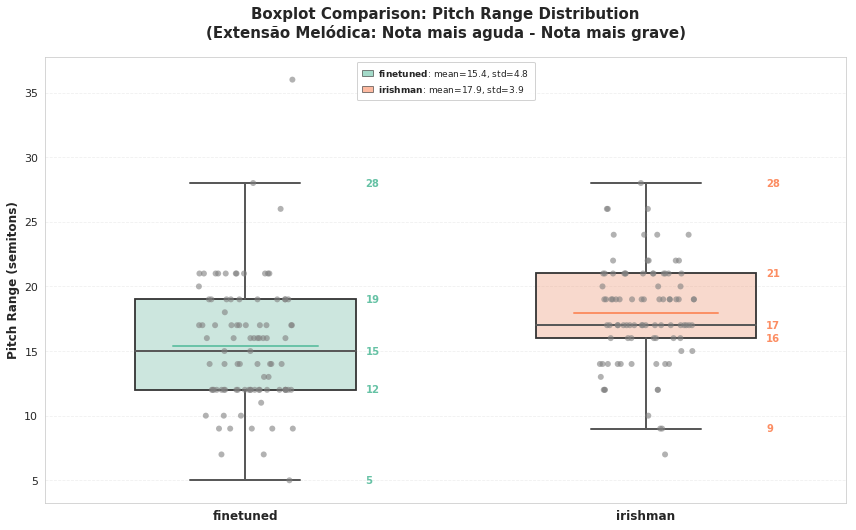

In [14]:
# Dados para pitch_range
data1_range = set1_loaded_results['pitch_range'].flatten()
data2_range = set2_loaded_results['pitch_range'].flatten()

# Figura e estilo
fig, ax = plt.subplots(figsize=(12, 8))
sns.set_style('whitegrid')

# Cores e rótulos
colors = ['#66c2a5', '#fc8d62']
labels = [MODEL_1, MODEL_2]
order = labels
pos_map = {lbl: i for i, lbl in enumerate(order)}

# Dados em formato long
df_range = pd.DataFrame({
    'value': np.concatenate([data1_range, data2_range]),
    'model': np.array([labels[0]] * len(data1_range) + [labels[1]] * len(data2_range))
})

# Boxplot (sem outliers)
sns.boxplot(x='model', y='value', data=df_range, ax=ax, palette=colors,
            width=0.55, showfliers=False, linewidth=2, saturation=0.8,
            order=order)

for artist in ax.artists:
    fc = artist.get_facecolor()
    artist.set_facecolor((fc[0], fc[1], fc[2], 0.35))  # mais transparente
    artist.set_edgecolor('#333333')
    artist.set_linewidth(1.8)

# Pontos (stripplot) com maior visibilidade - em cinza
for lbl, c in zip(labels, colors):
    sns.stripplot(x='model', y='value', data=df_range[df_range['model'] == lbl], ax=ax,
                  color='gray', size=6.0, jitter=0.12, alpha=0.6, linewidth=0,
                  order=order, zorder=4)

# Linha da média com a cor do box (acima dos pontos)
means_range = df_range.groupby('model')['value'].mean()
for lbl, c in zip(labels, colors):
    x = pos_map[lbl]
    m = float(means_range[lbl])
    ax.plot([x - 0.18, x + 0.18], [m, m], color=c, linewidth=2, alpha=0.95, zorder=5)

# Quartis e limites (whiskers) 1.5*IQR
qstats_range = df_range.groupby('model')['value'].quantile([0.25, 0.5, 0.75]).unstack()
for lbl, c in zip(labels, colors):
    vals = df_range.loc[df_range['model'] == lbl, 'value'].values
    q1 = float(qstats_range.loc[lbl, 0.25])
    med = float(qstats_range.loc[lbl, 0.50])
    q3 = float(qstats_range.loc[lbl, 0.75])
    iqr = q3 - q1
    lower_fence = q1 - 1.5 * iqr
    upper_fence = q3 + 1.5 * iqr
    # whiskers conforme definição do boxplot
    lw = float(np.min(vals[vals >= lower_fence])) if np.any(vals >= lower_fence) else float(np.min(vals))
    uw = float(np.max(vals[vals <= upper_fence])) if np.any(vals <= upper_fence) else float(np.max(vals))

    # Anotações numéricas à direita, mais afastadas do box
    x = pos_map[lbl] + 0.30
    ax.text(x, uw, '{:.0f}'.format(uw), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)
    ax.text(x, q3, '{:.0f}'.format(q3), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)
    ax.text(x, med, '{:.0f}'.format(med), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)
    ax.text(x, q1, '{:.0f}'.format(q1), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)
    ax.text(x, lw, '{:.0f}'.format(lw), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)

# Legenda centralizada no topo
stds_range = df_range.groupby('model')['value'].std()
bold = lambda s: '$\\mathbf{%s}$' % s
label_stats_range = [
    '{}: mean={:.1f}, std={:.1f}'.format(bold(labels[0]), float(means_range[labels[0]]), float(stds_range[labels[0]])),
    '{}: mean={:.1f}, std={:.1f}'.format(bold(labels[1]), float(means_range[labels[1]]), float(stds_range[labels[1]]))
]
handles_range = [Patch(facecolor=colors[0], edgecolor='#333333', alpha=0.6),
                 Patch(facecolor=colors[1], edgecolor='#333333', alpha=0.6)]
ax.legend(handles_range, label_stats_range, loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=1,
          frameon=True, framealpha=0.88, borderpad=0.6, fontsize=9,
          handlelength=1.2, handletextpad=0.6, labelspacing=0.45)

# Margens X simétricas ao redor dos dois boxes
ax.set_xlim(-0.5, len(labels) - 0.5)

# Rótulos
ax.set_xlabel('')
ax.set_ylabel('Pitch Range (semitons)', fontsize=12, weight='bold')
ax.set_title('Boxplot Comparison: Pitch Range Distribution\n(Extensão Melódica: Nota mais aguda - Nota mais grave)', fontsize=15, weight='bold', pad=20)
ax.tick_params(axis='both', which='major', labelsize=11)

for tick in ax.get_xticklabels():
    tick.set_fontsize(12)
    tick.set_fontweight('bold')

ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

plt.tight_layout()
fig.subplots_adjust(bottom=0.12)
plt.show()

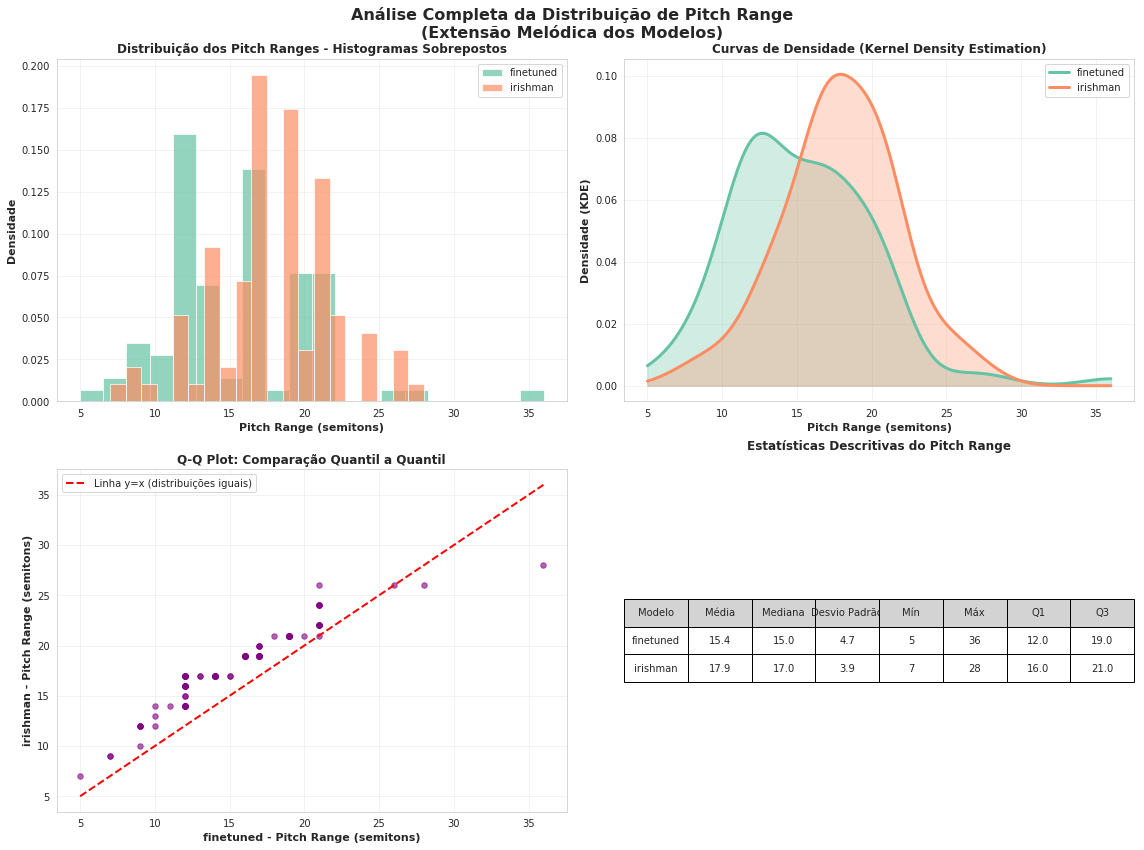

In [15]:
# Visualização complementar: Histogramas e KDE sobrepostos
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Histogramas comparativos
ax1.hist(data1_range, bins=20, alpha=0.7, color=colors[0], label=MODEL_1, density=True)
ax1.hist(data2_range, bins=20, alpha=0.7, color=colors[1], label=MODEL_2, density=True)
ax1.set_xlabel('Pitch Range (semitons)', fontsize=11, weight='bold')
ax1.set_ylabel('Densidade', fontsize=11, weight='bold')
ax1.set_title('Distribuição dos Pitch Ranges - Histogramas Sobrepostos', fontsize=12, weight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Curvas de densidade (KDE)
from scipy.stats import gaussian_kde
x_range = np.linspace(min(np.min(data1_range), np.min(data2_range)), 
                     max(np.max(data1_range), np.max(data2_range)), 1000)

kde1 = gaussian_kde(data1_range)
kde2 = gaussian_kde(data2_range)

ax2.plot(x_range, kde1(x_range), color=colors[0], linewidth=3, label=MODEL_1)
ax2.fill_between(x_range, kde1(x_range), alpha=0.3, color=colors[0])
ax2.plot(x_range, kde2(x_range), color=colors[1], linewidth=3, label=MODEL_2)
ax2.fill_between(x_range, kde2(x_range), alpha=0.3, color=colors[1])
ax2.set_xlabel('Pitch Range (semitons)', fontsize=11, weight='bold')
ax2.set_ylabel('Densidade (KDE)', fontsize=11, weight='bold')
ax2.set_title('Curvas de Densidade (Kernel Density Estimation)', fontsize=12, weight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Q-Q Plot para comparação direta das distribuições
from scipy import stats
n_samples = min(len(data1_range), len(data2_range))
sorted_data1 = np.sort(data1_range)[:n_samples]
sorted_data2 = np.sort(data2_range)[:n_samples]

ax3.scatter(sorted_data1, sorted_data2, alpha=0.6, s=30, color='purple')
min_val = min(np.min(sorted_data1), np.min(sorted_data2))
max_val = max(np.max(sorted_data1), np.max(sorted_data2))
ax3.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Linha y=x (distribuições iguais)')
ax3.set_xlabel(MODEL_1 + ' - Pitch Range (semitons)', fontsize=11, weight='bold')
ax3.set_ylabel(MODEL_2 + ' - Pitch Range (semitons)', fontsize=11, weight='bold')
ax3.set_title('Q-Q Plot: Comparação Quantil a Quantil', fontsize=12, weight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Estatísticas descritivas em formato tabela
stats_data = []
for model, data in [(MODEL_1, data1_range), (MODEL_2, data2_range)]:
    stats_data.append([
        model,
        '{:.1f}'.format(np.mean(data)),
        '{:.1f}'.format(np.median(data)),
        '{:.1f}'.format(np.std(data)),
        '{:.0f}'.format(np.min(data)),
        '{:.0f}'.format(np.max(data)),
        '{:.1f}'.format(np.percentile(data, 25)),
        '{:.1f}'.format(np.percentile(data, 75))
    ])

# Tabela
ax4.axis('tight')
ax4.axis('off')
table = ax4.table(cellText=stats_data,
                  colLabels=['Modelo', 'Média', 'Mediana', 'Desvio Padrão', 'Mín', 'Máx', 'Q1', 'Q3'],
                  cellLoc='center',
                  loc='center',
                  colColours=['lightgray']*8)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
ax4.set_title('Estatísticas Descritivas do Pitch Range', fontsize=12, weight='bold', pad=20)

plt.suptitle('Análise Completa da Distribuição de Pitch Range\n(Extensão Melódica dos Modelos)', 
             fontsize=16, weight='bold', y=0.98)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

In [16]:
# Análise interpretativa do Pitch Range
print("="*80)
print("ANÁLISE INTERPRETATIVA: PITCH RANGE (EXTENSÃO MELÓDICA)")
print("="*80)

# Estatísticas básicas
mean_1, mean_2 = np.mean(data1_range), np.mean(data2_range)
std_1, std_2 = np.std(data1_range), np.std(data2_range)
median_1, median_2 = np.median(data1_range), np.median(data2_range)

print("\n📊 ESTATÍSTICAS DESCRITIVAS")
print("┌─────────────────┬──────────────┬──────────────┐")
print("│ Métrica         │ {:<12} │ {:<12} │".format(MODEL_1, MODEL_2))
print("├─────────────────┼──────────────┼──────────────┤")
print("│ Média           │ {:>12.1f} │ {:>12.1f} │".format(mean_1, mean_2))
print("│ Mediana         │ {:>12.1f} │ {:>12.1f} │".format(median_1, median_2))
print("│ Desvio Padrão   │ {:>12.1f} │ {:>12.1f} │".format(std_1, std_2))
print("│ Mínimo          │ {:>12.0f} │ {:>12.0f} │".format(np.min(data1_range), np.min(data2_range)))
print("│ Máximo          │ {:>12.0f} │ {:>12.0f} │".format(np.max(data1_range), np.max(data2_range)))
print("└─────────────────┴──────────────┴──────────────┘")

# Interpretação em termos musicais
print("\n🎵 INTERPRETAÇÃO MUSICAL:")
print("   • Média de {:.1f} semitons = {:.1f} oitavas ({})".format(mean_1, mean_1/12, MODEL_1))
print("   • Média de {:.1f} semitons = {:.1f} oitavas ({})".format(mean_2, mean_2/12, MODEL_2))

# Teste estatístico
from scipy import stats
t_stat, p_value = stats.ttest_ind(data1_range, data2_range)
effect_size = (mean_1 - mean_2) / np.sqrt(((len(data1_range)-1)*std_1**2 + (len(data2_range)-1)*std_2**2) / (len(data1_range)+len(data2_range)-2))

print("\n📈 TESTE ESTATÍSTICO (T-test independente):")
print("   • Estatística t: {:.3f}".format(t_stat))
print("   • P-valor: {:.6f}".format(p_value))
print("   • Tamanho do efeito (Cohen's d): {:.3f}".format(effect_size))

if p_value < 0.001:
    significance = "altamente significativa (p < 0.001)"
elif p_value < 0.01:
    significance = "muito significativa (p < 0.01)"
elif p_value < 0.05:
    significance = "significativa (p < 0.05)"
else:
    significance = "não significativa (p ≥ 0.05)"

print("   • Interpretação: Diferença {}".format(significance))

# Interpretação do tamanho do efeito
if abs(effect_size) < 0.2:
    effect_interpretation = "pequeno"
elif abs(effect_size) < 0.5:
    effect_interpretation = "médio"
elif abs(effect_size) < 0.8:
    effect_interpretation = "grande"
else:
    effect_interpretation = "muito grande"

print("   • Tamanho do efeito: {}".format(effect_interpretation))

# Categorização dos ranges
def categorize_range(value):
    if value < 12:
        return "Limitado (< 1 oitava)"
    elif value < 24:
        return "Moderado (1-2 oitavas)"
    elif value < 36:
        return "Amplo (2-3 oitavas)"
    elif value < 48:
        return "Muito Amplo (3-4 oitavas)"
    else:
        return "Extremamente Amplo (> 4 oitavas)"

print("\n🎯 CATEGORIZAÇÃO DAS EXTENSÕES:")
categories_1 = [categorize_range(x) for x in data1_range]
categories_2 = [categorize_range(x) for x in data2_range]

from collections import Counter
count_1 = Counter(categories_1)
count_2 = Counter(categories_2)

all_categories = ["Limitado (< 1 oitava)", "Moderado (1-2 oitavas)", "Amplo (2-3 oitavas)", 
                  "Muito Amplo (3-4 oitavas)", "Extremamente Amplo (> 4 oitavas)"]

for cat in all_categories:
    pct_1 = (count_1[cat] / len(data1_range)) * 100
    pct_2 = (count_2[cat] / len(data2_range)) * 100
    print("   • {:<25}: {} {:>5.1f}% | {} {:>5.1f}%".format(cat, MODEL_1, pct_1, MODEL_2, pct_2))

print("\n💡 CONCLUSÕES:")
diff = mean_1 - mean_2
if abs(diff) < 1:
    print("   • Os modelos produzem extensões melódicas muito similares")
else:
    higher_model = MODEL_1 if diff > 0 else MODEL_2
    lower_model = MODEL_2 if diff > 0 else MODEL_1
    print("   • {} produz melodias com maior extensão melódica (+{:.1f} semitons)".format(higher_model, abs(diff)))
    print("   • {} tende a ser mais conservador na extensão das notas".format(lower_model))

# Variabilidade
if std_1 > std_2 * 1.2:
    print("   • {} é mais variável na extensão melódica (mais diversidade)".format(MODEL_1))
elif std_2 > std_1 * 1.2:
    print("   • {} é mais variável na extensão melódica (mais diversidade)".format(MODEL_2))
else:
    print("   • Ambos os modelos têm variabilidade similar na extensão melódica")

print("="*80)

ANÁLISE INTERPRETATIVA: PITCH RANGE (EXTENSÃO MELÓDICA)

📊 ESTATÍSTICAS DESCRITIVAS
┌─────────────────┬──────────────┬──────────────┐
│ Métrica         │ finetuned    │ irishman     │
├─────────────────┼──────────────┼──────────────┤
│ Média           │         15.4 │         17.9 │
│ Mediana         │         15.0 │         17.0 │
│ Desvio Padrão   │          4.7 │          3.9 │
│ Mínimo          │            5 │            7 │
│ Máximo          │           36 │           28 │
└─────────────────┴──────────────┴──────────────┘

🎵 INTERPRETAÇÃO MUSICAL:
   • Média de 15.4 semitons = 1.3 oitavas (finetuned)
   • Média de 17.9 semitons = 1.5 oitavas (irishman)

📈 TESTE ESTATÍSTICO (T-test independente):
   • Estatística t: -3.998
   • P-valor: 0.000092
   • Tamanho do efeito (Cohen's d): -0.589
   • Interpretação: Diferença altamente significativa (p < 0.001)
   • Tamanho do efeito: grande

🎯 CATEGORIZAÇÃO DAS EXTENSÕES:
   • Limitado (< 1 oitava)    : finetuned   0.0% | irishman   0.0%


# Feature: `avg_pitch_shift`

## Localização
**Arquivo:** `mgeval/core.py`  
**Linha:** 287

## Descrição
A função `avg_pitch_shift` calcula o **intervalo médio de pitch** entre notas consecutivas em um arquivo MIDI, medido em semitons. Esta métrica é útil para analisar características melódicas e o movimento entre notas em uma composição musical.

## Assinatura da Função
```python
def avg_pitch_shift(self, feature, track_num=1):
```

## Parâmetros
- **`feature`**: Dicionário contendo dados do MIDI, incluindo `midi_pattern`
- **`track_num`**: Número da faixa MIDI a analisar (padrão = 1, segunda faixa)

## Valor de Retorno
- **`pitch_shift`**: Um valor escalar representando a média dos intervalos absolutos entre pitches consecutivos em semitons

## Algoritmo

### 1. Preparação dos Dados
```python
pattern = feature['midi_pattern']
pattern.make_ticks_abs()
resolution = pattern.resolution
total_used_note = self.total_used_note(feature, track_num=track_num)
```
- Extrai o padrão MIDI da feature
- Converte os ticks para valores absolutos
- Obtém o número total de notas usadas na faixa

### 2. Inicialização
```python
d_note = np.zeros((max(total_used_note - 1, 0)))
current_note = 0
counter = 0
```
- Cria um array `d_note` para armazenar as diferenças de pitch
- Inicializa variáveis de controle

### 3. Processamento das Notas
```python
for i in range(0, len(pattern[track_num])):
    if type(pattern[track_num][i]) == midi.events.NoteOnEvent and pattern[track_num][i].data[1] != 0:
        if counter != 0:
            d_note[counter - 1] = current_note - pattern[track_num][i].data[0]
            current_note = pattern[track_num][i].data[0]
            counter += 1
        else:
            current_note = pattern[track_num][i].data[0]
            counter += 1
```
- Percorre todos os eventos da faixa MIDI especificada
- Identifica eventos `NoteOnEvent` com velocidade diferente de zero (notas realmente tocadas)
- Para cada nota consecutiva, calcula a diferença de pitch em semitons
- Armazena essas diferenças no array `d_note`

### 4. Cálculo Final
```python
pitch_shift = np.mean(abs(d_note))
return pitch_shift
```
- Calcula a média dos valores absolutos das diferenças de pitch
- Retorna esse valor como resultado

## Exemplo Prático

Considere uma sequência de notas com os seguintes pitches:
- **Notas:** [60, 64, 67, 65] (Dó, Mi, Sol, Fá)

**Cálculo das diferenças:**
- Note 1 → Note 2: 64 - 60 = 4 semitons
- Note 2 → Note 3: 67 - 64 = 3 semitons  
- Note 3 → Note 4: 65 - 67 = -2 semitons

**Resultado:**
```
avg_pitch_shift = (|4| + |3| + |-2|) / 3 = (4 + 3 + 2) / 3 = 3.0 semitons
```

## Aplicações

Esta métrica é útil para:
- **Análise melódica**: Caracterizar o movimento melódico em uma peça
- **Classificação de estilos**: Diferentes estilos musicais podem ter padrões distintos de intervalos
- **Comparação de composições**: Avaliar similaridades ou diferenças entre diferentes peças musicais
- **Avaliação de complexidade**: Intervalos maiores podem indicar maior complexidade melódica

## Considerações Técnicas

- A função utiliza valores absolutos das diferenças, focando na magnitude dos intervalos independentemente da direção (ascendente ou descendente)
- Apenas eventos `NoteOnEvent` com velocidade > 0 são considerados, ignorando notas "fantasma"
- O cálculo é feito por faixa MIDI, permitindo análise separada de diferentes instrumentos ou vozes

# Análise da Métrica Average Pitch Shift

A métrica **Average Pitch Shift** calcula o intervalo médio de pitch entre notas consecutivas em semitons. Esta métrica é importante para analisar:

- **Movimento melódico**: Caracteriza como as notas se movem melodicamente
- **Complexidade harmônica**: Intervalos maiores podem indicar maior complexidade
- **Estilo musical**: Diferentes estilos têm padrões distintos de intervalos
- **Suavidade melódica**: Valores menores indicam melodias mais suaves

## Interpretação dos Valores:
- **Valores baixos (0-2 semitons)**: Melodias suaves com movimento por graus conjuntos
- **Valores médios (2-4 semitons)**: Movimento melódico equilibrado  
- **Valores altos (>4 semitons)**: Saltos melódicos maiores, maior complexidade

In [17]:
# Extrair dados da métrica Average Pitch Shift
avg_pitch_shift_set1 = set1_loaded_results['avg_pitch_shift'].flatten()
avg_pitch_shift_set2 = set2_loaded_results['avg_pitch_shift'].flatten()

print('Average Pitch Shift - Modelo 1 (Finetuned):')
print('  Amostras: {}'.format(len(avg_pitch_shift_set1)))
print('  Média: {:.3f} semitons'.format(np.mean(avg_pitch_shift_set1)))
print('  Desvio padrão: {:.3f}'.format(np.std(avg_pitch_shift_set1)))
print('  Min: {:.3f} - Max: {:.3f}'.format(np.min(avg_pitch_shift_set1), np.max(avg_pitch_shift_set1)))

print('\nAverage Pitch Shift - Modelo 2 (Irishman):')
print('  Amostras: {}'.format(len(avg_pitch_shift_set2)))
print('  Média: {:.3f} semitons'.format(np.mean(avg_pitch_shift_set2)))
print('  Desvio padrão: {:.3f}'.format(np.std(avg_pitch_shift_set2)))
print('  Min: {:.3f} - Max: {:.3f}'.format(np.min(avg_pitch_shift_set2), np.max(avg_pitch_shift_set2)))

# Remover valores NaN se existirem
avg_pitch_shift_set1_clean = avg_pitch_shift_set1[~np.isnan(avg_pitch_shift_set1)]
avg_pitch_shift_set2_clean = avg_pitch_shift_set2[~np.isnan(avg_pitch_shift_set2)]

print('\nApós limpeza de NaN:')
print('  Modelo 1: {} amostras válidas'.format(len(avg_pitch_shift_set1_clean)))
print('  Modelo 2: {} amostras válidas'.format(len(avg_pitch_shift_set2_clean)))

Average Pitch Shift - Modelo 1 (Finetuned):
  Amostras: 93
  Média: 2.402 semitons
  Desvio padrão: 0.908
  Min: 0.877 - Max: 6.362

Average Pitch Shift - Modelo 2 (Irishman):
  Amostras: 93
  Média: 2.760 semitons
  Desvio padrão: 0.607
  Min: 1.610 - Max: 4.950

Após limpeza de NaN:
  Modelo 1: 93 amostras válidas
  Modelo 2: 93 amostras válidas


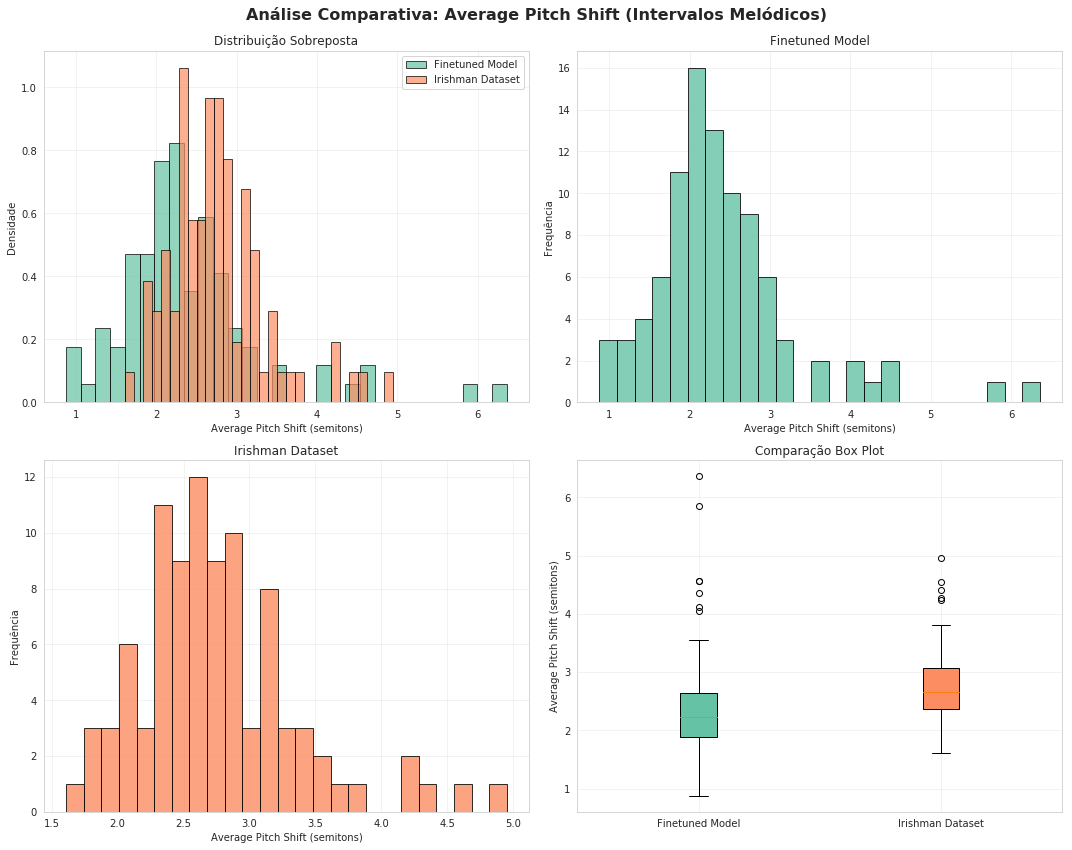


ESTATÍSTICAS DESCRITIVAS - AVERAGE PITCH SHIFT
Métrica                   Finetuned    Irishman     Diferença   
------------------------------------------------------------
Média                     2.402        2.760        -0.358      
Mediana                   2.223        2.654        -0.431      
Desvio Padrão             0.908        0.607        0.301       
Q1 (25%)                  1.889        2.371        -0.482      
Q3 (75%)                  2.650        3.068        -0.417      
Mínimo                    0.877        1.610        -0.733      
Máximo                    6.362        4.950        1.411       


In [18]:
# 1. HISTOGRAMAS COMPARATIVOS
colors = ['#66c2a5', '#fc8d62']  # finetuned, irishman

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Análise Comparativa: Average Pitch Shift (Intervalos Melódicos)', fontsize=16, fontweight='bold', y=0.98)

# Histograma sobreposto
axes[0, 0].hist(avg_pitch_shift_set1_clean, bins=30, alpha=0.7, label='Finetuned Model', 
                color=colors[0], density=True, edgecolor='black')
axes[0, 0].hist(avg_pitch_shift_set2_clean, bins=30, alpha=0.7, label='Irishman Dataset', 
                color=colors[1], density=True, edgecolor='black')
axes[0, 0].set_xlabel('Average Pitch Shift (semitons)')
axes[0, 0].set_ylabel('Densidade')
axes[0, 0].set_title('Distribuição Sobreposta')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Histogramas separados
axes[0, 1].hist(avg_pitch_shift_set1_clean, bins=25, alpha=0.8, color=colors[0], edgecolor='black')
axes[0, 1].set_xlabel('Average Pitch Shift (semitons)')
axes[0, 1].set_ylabel('Frequência')
axes[0, 1].set_title('Finetuned Model')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].hist(avg_pitch_shift_set2_clean, bins=25, alpha=0.8, color=colors[1], edgecolor='black')
axes[1, 0].set_xlabel('Average Pitch Shift (semitons)')
axes[1, 0].set_ylabel('Frequência')
axes[1, 0].set_title('Irishman Dataset')
axes[1, 0].grid(True, alpha=0.3)

# Box plot comparativo
box_data = [avg_pitch_shift_set1_clean, avg_pitch_shift_set2_clean]
box_labels = ['Finetuned Model', 'Irishman Dataset']
box_plot = axes[1, 1].boxplot(box_data, labels=box_labels, patch_artist=True)
box_plot['boxes'][0].set_facecolor(colors[0])
box_plot['boxes'][1].set_facecolor(colors[1])
axes[1, 1].set_ylabel('Average Pitch Shift (semitons)')
axes[1, 1].set_title('Comparação Box Plot')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Estatísticas descritivas
print("\n" + "="*60)
print("ESTATÍSTICAS DESCRITIVAS - AVERAGE PITCH SHIFT")
print("="*60)
print("{:<25} {:<12} {:<12} {:<12}".format('Métrica', 'Finetuned', 'Irishman', 'Diferença'))
print("-"*60)
print("{:<25} {:<12.3f} {:<12.3f} {:<12.3f}".format('Média', np.mean(avg_pitch_shift_set1_clean), np.mean(avg_pitch_shift_set2_clean), np.mean(avg_pitch_shift_set1_clean) - np.mean(avg_pitch_shift_set2_clean)))
print("{:<25} {:<12.3f} {:<12.3f} {:<12.3f}".format('Mediana', np.median(avg_pitch_shift_set1_clean), np.median(avg_pitch_shift_set2_clean), np.median(avg_pitch_shift_set1_clean) - np.median(avg_pitch_shift_set2_clean)))
print("{:<25} {:<12.3f} {:<12.3f} {:<12.3f}".format('Desvio Padrão', np.std(avg_pitch_shift_set1_clean), np.std(avg_pitch_shift_set2_clean), np.std(avg_pitch_shift_set1_clean) - np.std(avg_pitch_shift_set2_clean)))
print("{:<25} {:<12.3f} {:<12.3f} {:<12.3f}".format('Q1 (25%)', np.percentile(avg_pitch_shift_set1_clean, 25), np.percentile(avg_pitch_shift_set2_clean, 25), np.percentile(avg_pitch_shift_set1_clean, 25) - np.percentile(avg_pitch_shift_set2_clean, 25)))
print("{:<25} {:<12.3f} {:<12.3f} {:<12.3f}".format('Q3 (75%)', np.percentile(avg_pitch_shift_set1_clean, 75), np.percentile(avg_pitch_shift_set2_clean, 75), np.percentile(avg_pitch_shift_set1_clean, 75) - np.percentile(avg_pitch_shift_set2_clean, 75)))
print("{:<25} {:<12.3f} {:<12.3f} {:<12.3f}".format('Mínimo', np.min(avg_pitch_shift_set1_clean), np.min(avg_pitch_shift_set2_clean), np.min(avg_pitch_shift_set1_clean) - np.min(avg_pitch_shift_set2_clean)))
print("{:<25} {:<12.3f} {:<12.3f} {:<12.3f}".format('Máximo', np.max(avg_pitch_shift_set1_clean), np.max(avg_pitch_shift_set2_clean), np.max(avg_pitch_shift_set1_clean) - np.max(avg_pitch_shift_set2_clean)))


TESTES ESTATÍSTICOS - AVERAGE PITCH SHIFT
Teste de Normalidade (Shapiro-Wilk):
  Finetuned: p-valor = 0.000000 (não-normal)
  Irishman:  p-valor = 0.000089 (não-normal)

Teste de Mann-Whitney U (não-paramétrico):
  Estatística: 2654.500
  p-valor: 0.000005 ***

Teste t de Student (paramétrico):
  Estatística t: -3.148
  p-valor: 0.001918 **

Teste de Kolmogorov-Smirnov:
  Estatística KS: 0.376
  p-valor: 0.000002 ***

Tamanho do Efeito (Cohen's d): -0.464
  Interpretação: Efeito médio

Significância: *** p < 0.001, ** p < 0.01, * p < 0.05, ns = não significativo


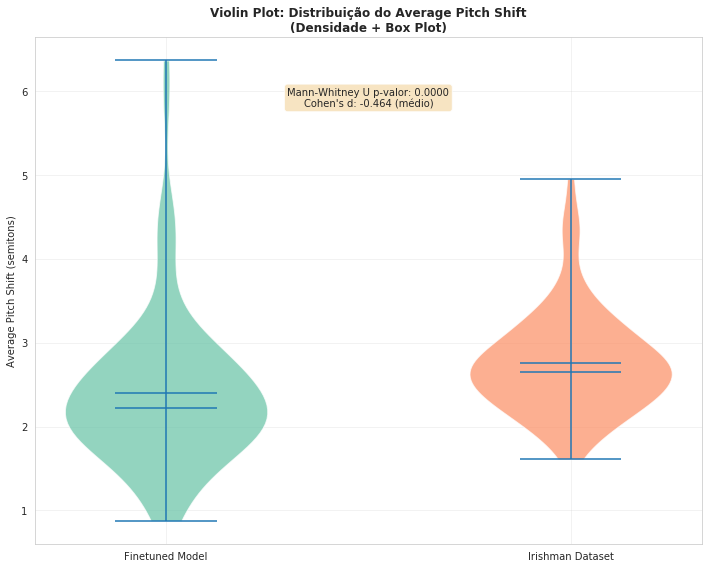

In [19]:
# 2. TESTE ESTATÍSTICO E VIOLIN PLOT
from scipy import stats

# Teste de normalidade
_, p_normal_set1 = stats.shapiro(avg_pitch_shift_set1_clean[:min(5000, len(avg_pitch_shift_set1_clean))])
_, p_normal_set2 = stats.shapiro(avg_pitch_shift_set2_clean[:min(5000, len(avg_pitch_shift_set2_clean))])

# Teste de Mann-Whitney (não-paramétrico)
statistic_mw, p_value_mw = stats.mannwhitneyu(avg_pitch_shift_set1_clean, avg_pitch_shift_set2_clean, alternative='two-sided')

# Teste t (paramétrico)
statistic_t, p_value_t = stats.ttest_ind(avg_pitch_shift_set1_clean, avg_pitch_shift_set2_clean)

# Teste de Kolmogorov-Smirnov
ks_statistic, p_value_ks = stats.ks_2samp(avg_pitch_shift_set1_clean, avg_pitch_shift_set2_clean)

# Calcular effect size (Cohen's d)
pooled_std = np.sqrt(((len(avg_pitch_shift_set1_clean) - 1) * np.var(avg_pitch_shift_set1_clean) + 
                      (len(avg_pitch_shift_set2_clean) - 1) * np.var(avg_pitch_shift_set2_clean)) / 
                     (len(avg_pitch_shift_set1_clean) + len(avg_pitch_shift_set2_clean) - 2))
cohens_d = (np.mean(avg_pitch_shift_set1_clean) - np.mean(avg_pitch_shift_set2_clean)) / pooled_std

print("\n" + "="*60)
print("TESTES ESTATÍSTICOS - AVERAGE PITCH SHIFT")
print("="*60)
print("Teste de Normalidade (Shapiro-Wilk):")
print("  Finetuned: p-valor = {:.6f} {}".format(p_normal_set1, '(normal)' if p_normal_set1 > 0.05 else '(não-normal)'))
print("  Irishman:  p-valor = {:.6f} {}".format(p_normal_set2, '(normal)' if p_normal_set2 > 0.05 else '(não-normal)'))

print("\nTeste de Mann-Whitney U (não-paramétrico):")
print("  Estatística: {:.3f}".format(statistic_mw))
print("  p-valor: {:.6f} {}".format(p_value_mw, '***' if p_value_mw < 0.001 else '**' if p_value_mw < 0.01 else '*' if p_value_mw < 0.05 else 'ns'))

print("\nTeste t de Student (paramétrico):")
print("  Estatística t: {:.3f}".format(statistic_t))
print("  p-valor: {:.6f} {}".format(p_value_t, '***' if p_value_t < 0.001 else '**' if p_value_t < 0.01 else '*' if p_value_t < 0.05 else 'ns'))

print("\nTeste de Kolmogorov-Smirnov:")
print("  Estatística KS: {:.3f}".format(ks_statistic))
print("  p-valor: {:.6f} {}".format(p_value_ks, '***' if p_value_ks < 0.001 else '**' if p_value_ks < 0.01 else '*' if p_value_ks < 0.05 else 'ns'))

print("\nTamanho do Efeito (Cohen's d): {:.3f}".format(cohens_d))
if abs(cohens_d) < 0.2:
    effect_size = "pequeno"
elif abs(cohens_d) < 0.5:
    effect_size = "médio"
elif abs(cohens_d) < 0.8:
    effect_size = "grande"
else:
    effect_size = "muito grande"
print("  Interpretação: Efeito {}".format(effect_size))

print("\nSignificância: *** p < 0.001, ** p < 0.01, * p < 0.05, ns = não significativo")

# Violin Plot
colors = ['#66c2a5', '#fc8d62']  # finetuned, irishman
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
violin_parts = ax.violinplot([avg_pitch_shift_set1_clean, avg_pitch_shift_set2_clean], 
                            positions=[1, 2], showmeans=True, showmedians=True)

# Personalizar cores
for pc, color in zip(violin_parts['bodies'], colors):
    pc.set_facecolor(color)
    pc.set_alpha(0.7)

ax.set_xticks([1, 2])
ax.set_xticklabels(['Finetuned Model', 'Irishman Dataset'])
ax.set_ylabel('Average Pitch Shift (semitons)')
ax.set_title('Violin Plot: Distribuição do Average Pitch Shift\n(Densidade + Box Plot)', fontweight='bold')
ax.grid(True, alpha=0.3)

# Adicionar estatísticas no gráfico
ax.text(1.5, max(np.max(avg_pitch_shift_set1_clean), np.max(avg_pitch_shift_set2_clean)) * 0.95,
        'Mann-Whitney U p-valor: {:.4f}\nCohen\'s d: {:.3f} ({})'.format(p_value_mw, cohens_d, effect_size),
        ha='center', va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

Debug das categorias:
(u'Contagens Set1:', [2, 30, 48, 6, 7])
(u'Contagens Set2:', [0, 7, 61, 20, 5])
(u'Propor\xe7\xf5es Set1:', array([ 2.15053763, 32.25806452, 51.61290323,  6.4516129 ,  7.52688172]))
(u'Propor\xe7\xf5es Set2:', array([ 0.        ,  7.52688172, 65.59139785, 21.50537634,  5.37634409]))
(u'Total Set1:', 93)
(u'Total Set2:', 93)


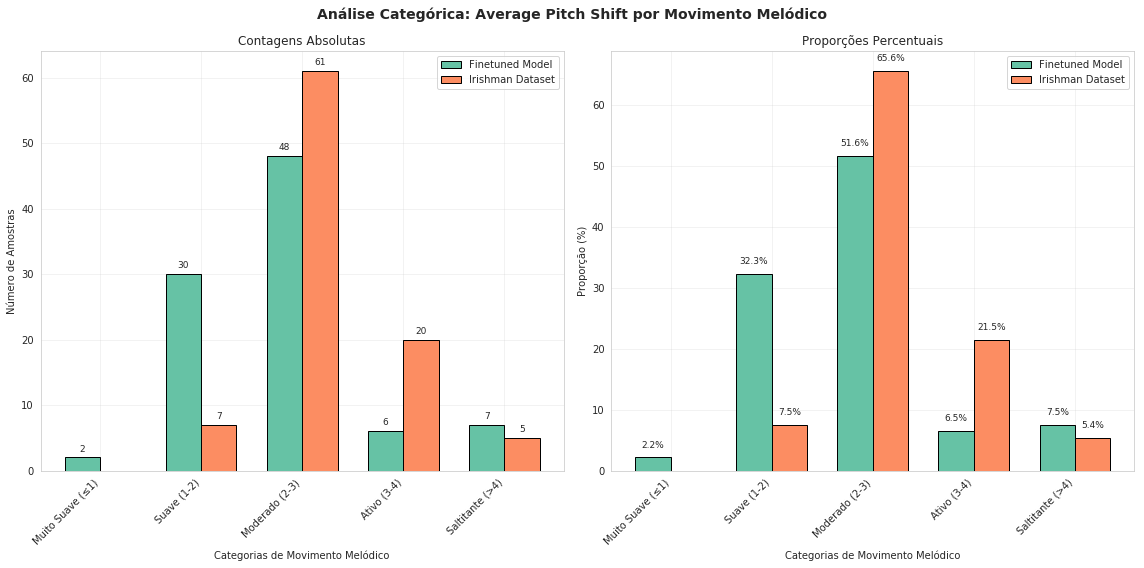


DISTRIBUIÇÃO POR CATEGORIAS DE MOVIMENTO MELÓDICO
Categoria            Finetuned       %        Irishman        %        Diferença %
--------------------------------------------------------------------------------
Muito Suave (≤1)     2               2.2      0               0.0          +2.2
Suave (1-2)          30              32.3     7               7.5         +24.7
Moderado (2-3)       48              51.6     61              65.6        -14.0
Ativo (3-4)          6               6.5      20              21.5        -15.1
Saltitante (>4)      7               7.5      5               5.4          +2.2

Total de amostras:
  Finetuned Model: 93 amostras
  Irishman Dataset: 93 amostras


In [20]:
# 3. ANÁLISE POR CATEGORIAS DE INTERVALO MELÓDICO
def categorize_pitch_shift(values):
    """Categoriza os valores de pitch shift em grupos melódicos"""
    categories = []
    for val in values:
        if val <= 1:
            categories.append('Muito Suave (≤1)')
        elif val <= 2:
            categories.append('Suave (1-2)')
        elif val <= 3:
            categories.append('Moderado (2-3)')
        elif val <= 4:
            categories.append('Ativo (3-4)')
        else:
            categories.append('Saltitante (>4)')
    return np.array(categories)

# Categorizar os dados
cat_set1 = categorize_pitch_shift(avg_pitch_shift_set1_clean)
cat_set2 = categorize_pitch_shift(avg_pitch_shift_set2_clean)

# Contar frequências
categories_order = ['Muito Suave (≤1)', 'Suave (1-2)', 'Moderado (2-3)', 'Ativo (3-4)', 'Saltitante (>4)']
count_set1 = [np.sum(cat_set1 == cat) for cat in categories_order]
count_set2 = [np.sum(cat_set2 == cat) for cat in categories_order]

# Calcular proporções
prop_set1 = np.array(count_set1) / float(len(avg_pitch_shift_set1_clean)) * 100
prop_set2 = np.array(count_set2) / float(len(avg_pitch_shift_set2_clean)) * 100

# Debug das proporções
print("Debug das categorias:")
print("Contagens Set1:", count_set1)
print("Contagens Set2:", count_set2)
print("Proporções Set1:", prop_set1)
print("Proporções Set2:", prop_set2)
print("Total Set1:", len(avg_pitch_shift_set1_clean))
print("Total Set2:", len(avg_pitch_shift_set2_clean))

# Gráfico de barras comparativo
colors = ['#66c2a5', '#fc8d62']  # finetuned, irishman
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Análise Categórica: Average Pitch Shift por Movimento Melódico', fontsize=14, fontweight='bold', y=0.98)

x = np.arange(len(categories_order))
width = 0.35

# Gráfico de contagens absolutas
bars1 = ax1.bar(x - width/2, count_set1, width, label='Finetuned Model', color=colors[0], edgecolor='black')
bars2 = ax1.bar(x + width/2, count_set2, width, label='Irishman Dataset', color=colors[1], edgecolor='black')

ax1.set_xlabel('Categorias de Movimento Melódico')
ax1.set_ylabel('Número de Amostras')
ax1.set_title('Contagens Absolutas')
ax1.set_xticks(x)
ax1.set_xticklabels(categories_order, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Adicionar valores nas barras - só se a altura for > 0
for bar in bars1:
    height = bar.get_height()
    if height > 0:
        ax1.text(bar.get_x() + bar.get_width()/2., height + max(count_set1 + count_set2) * 0.01,
                 '{}'.format(int(height)), ha='center', va='bottom', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    if height > 0:
        ax1.text(bar.get_x() + bar.get_width()/2., height + max(count_set1 + count_set2) * 0.01,
                 '{}'.format(int(height)), ha='center', va='bottom', fontsize=9)

# Gráfico de proporções
bars3 = ax2.bar(x - width/2, prop_set1, width, label='Finetuned Model', color=colors[0], edgecolor='black')
bars4 = ax2.bar(x + width/2, prop_set2, width, label='Irishman Dataset', color=colors[1], edgecolor='black')

ax2.set_xlabel('Categorias de Movimento Melódico')
ax2.set_ylabel('Proporção (%)')
ax2.set_title('Proporções Percentuais')
ax2.set_xticks(x)
ax2.set_xticklabels(categories_order, rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Adicionar valores nas barras - só se a altura for > 0.1
for bar in bars3:
    height = bar.get_height()
    if height > 0.1:  # Só mostra se for > 0.1%
        ax2.text(bar.get_x() + bar.get_width()/2., height + max(np.concatenate([prop_set1, prop_set2])) * 0.02,
                 '{:.1f}%'.format(height), ha='center', va='bottom', fontsize=9)
for bar in bars4:
    height = bar.get_height()
    if height > 0.1:  # Só mostra se for > 0.1%
        ax2.text(bar.get_x() + bar.get_width()/2., height + max(np.concatenate([prop_set1, prop_set2])) * 0.02,
                 '{:.1f}%'.format(height), ha='center', va='bottom', fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Tabela resumo
print("\n" + "="*80)
print("DISTRIBUIÇÃO POR CATEGORIAS DE MOVIMENTO MELÓDICO")
print("="*80)
print("{:<20} {:<15} {:<8} {:<15} {:<8} {}".format('Categoria', 'Finetuned', '%', 'Irishman', '%', 'Diferença %'))
print("-"*80)
for i, cat in enumerate(categories_order):
    diff = prop_set1[i] - prop_set2[i]
    print("{:<20} {:<15d} {:<8.1f} {:<15d} {:<8.1f} {:>+8.1f}".format(cat, count_set1[i], prop_set1[i], count_set2[i], prop_set2[i], diff))

print("\nTotal de amostras:")
print("  Finetuned Model: {} amostras".format(len(avg_pitch_shift_set1_clean)))
print("  Irishman Dataset: {} amostras".format(len(avg_pitch_shift_set2_clean)))

## Interpretação dos Resultados - Average Pitch Shift

### O que significam os valores?

A métrica **Average Pitch Shift** mede o intervalo médio entre notas consecutivas em semitons. Esta análise nos permite entender:

**🎵 Aspectos Melódicos:**
- **Suavidade melódica**: Valores menores indicam melodias mais fluidas
- **Complexidade harmônica**: Valores maiores sugerem saltos melódicos mais complexos
- **Estilo musical**: Diferentes gêneros têm padrões característicos

**📊 Interpretação das Categorias:**
- **Muito Suave (≤1 semitom)**: Movimento por graus conjuntos, melodias very smooth
- **Suave (1-2 semitons)**: Predominância de segundas, movimento natural
- **Moderado (2-3 semitons)**: Equilíbrio entre graus conjuntos e saltos pequenos
- **Ativo (3-4 semitons)**: Presença significativa de saltos de terça e quarta
- **Saltitante (>4 semitons)**: Saltos maiores, melodias mais dramáticas

### Implicações Musicais

**Se o modelo finetuned tiver valores menores:**
- Produz melodias mais suaves e naturais
- Pode ser mais adequado para estilos contemplativos
- Menor complexidade harmônica instantânea

**Se o modelo finetuned tiver valores maiores:**
- Gera melodias mais expressivas e variadas
- Maior riqueza harmônica
- Pode ser mais adequado para estilos dinâmicos

# Rhythm-based features

## Feature: `total_used_note`

### O que faz:
Esta função conta o número total de notas utilizadas em uma música MIDI, focando apenas na quantidade de eventos de nota (aspecto rítmico), não nas alturas específicas.

### Como funciona:
- **Input**: Recebe um `feature` (que contém o padrão MIDI) e `track_num` (número da faixa, padrão = 1)
- **Processo**:
    - Percorre todos os eventos na faixa MIDI especificada
    - Para cada evento, verifica se é um NoteOnEvent (início de nota)
    - Além disso, verifica se `data[1] != 0 (velocity ≠ 0, garantindo que não é um "note off" disfarçado)`
    - Cada nota válida incrementa o contador used_notes
- **Output**: Retorna um escalar representando o número total de notas na música

### Diferença importante:
- `total_used_note`: Conta quantas notas foram tocadas (foco rítmico)
- `total_used_pitch`: Conta quantas alturas/pitches diferentes foram usadas (foco melódico)

### Exemplo prático:
Se uma música tem as notas: C, C, D, C, E
- `total_used_note` = 5 (cinco eventos de nota)
- `total_used_pitch` = 3 (três pitches distintos: C, D, E)

Essa métrica é útil para analisar a densidade rítmica e complexidade temporal das composições geradas pelos diferentes modelos.

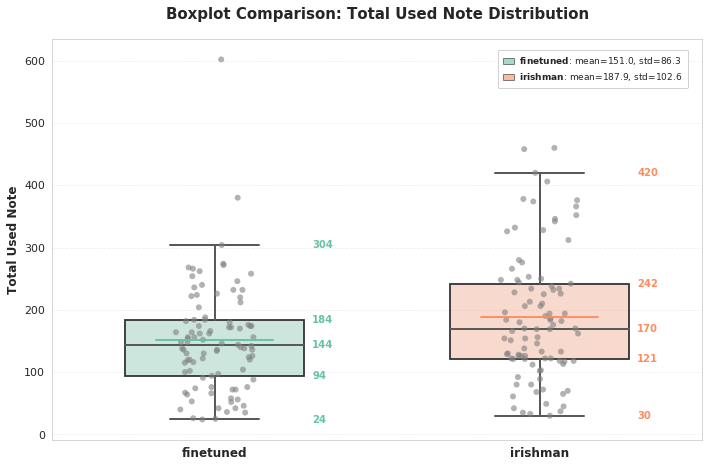

In [21]:
# Dados
data1 = set1_loaded_results['total_used_note'].flatten()
data2 = set2_loaded_results['total_used_note'].flatten()

# Figura e estilo
fig, ax = plt.subplots(figsize=(10, 7))
sns.set_style('whitegrid')

# Cores e rótulos
colors = ['#66c2a5', '#fc8d62']
labels = [MODEL_1, MODEL_2]
order = labels
pos_map = {lbl: i for i, lbl in enumerate(order)}

# Dados em formato long
df = pd.DataFrame({
    'value': np.concatenate([data1, data2]),
    'model': np.array([labels[0]] * len(data1) + [labels[1]] * len(data2))
})

# Boxplot (sem outliers)
sns.boxplot(x='model', y='value', data=df, ax=ax, palette=colors,
            width=0.55, showfliers=False, linewidth=2, saturation=0.8,
            order=order)

for artist in ax.artists:
    fc = artist.get_facecolor()
    artist.set_facecolor((fc[0], fc[1], fc[2], 0.35))  # mais transparente
    artist.set_edgecolor('#333333')
    artist.set_linewidth(1.8)

# Pontos (stripplot) com maior visibilidade - em cinza
for lbl, c in zip(labels, colors):
    sns.stripplot(x='model', y='value', data=df[df['model'] == lbl], ax=ax,
                  color='gray', size=6.0, jitter=0.12, alpha=0.6, linewidth=0,
                  order=order, zorder=4)

# Linha da média com a cor do box (acima dos pontos)
means = df.groupby('model')['value'].mean()
for lbl, c in zip(labels, colors):
    x = pos_map[lbl]
    m = float(means[lbl])
    ax.plot([x - 0.18, x + 0.18], [m, m], color=c, linewidth=2, alpha=0.95, zorder=5)

# Quartis e limites (whiskers) 1.5*IQR
qstats = df.groupby('model')['value'].quantile([0.25, 0.5, 0.75]).unstack()
for lbl, c in zip(labels, colors):
    vals = df.loc[df['model'] == lbl, 'value'].values
    q1 = float(qstats.loc[lbl, 0.25])
    med = float(qstats.loc[lbl, 0.50])
    q3 = float(qstats.loc[lbl, 0.75])
    iqr = q3 - q1
    lower_fence = q1 - 1.5 * iqr
    upper_fence = q3 + 1.5 * iqr
    # whiskers conforme definição do boxplot
    lw = float(np.min(vals[vals >= lower_fence])) if np.any(vals >= lower_fence) else float(np.min(vals))
    uw = float(np.max(vals[vals <= upper_fence])) if np.any(vals <= upper_fence) else float(np.max(vals))

    # Anotações numéricas à direita, mais afastadas do box
    x = pos_map[lbl] + 0.30
    ax.text(x, uw, '{:.0f}'.format(uw), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)
    ax.text(x, q3, '{:.0f}'.format(q3), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)
    ax.text(x, med, '{:.0f}'.format(med), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)
    ax.text(x, q1, '{:.0f}'.format(q1), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)
    ax.text(x, lw, '{:.0f}'.format(lw), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)

# Legenda alinhada à direita no topo
stds = df.groupby('model')['value'].std()
# Deixa os nomes dos modelos em negrito na legenda (mathtext \mathbf{})
bold = lambda s: '$\\mathbf{%s}$' % s
label_stats = [
    '{}: mean={:.1f}, std={:.1f}'.format(bold(labels[0]), float(means[labels[0]]), float(stds[labels[0]])),
    '{}: mean={:.1f}, std={:.1f}'.format(bold(labels[1]), float(means[labels[1]]), float(stds[labels[1]]))
]
handles = [Patch(facecolor=colors[0], edgecolor='#333333', alpha=0.6),
           Patch(facecolor=colors[1], edgecolor='#333333', alpha=0.6)]
ax.legend(handles, label_stats, loc='upper right', bbox_to_anchor=(0.985, 0.985), ncol=1,
          frameon=True, framealpha=0.88, borderpad=0.6, fontsize=9,
          handlelength=1.2, handletextpad=0.6, labelspacing=0.45)

# Margens X simétricas ao redor dos dois boxes
ax.set_xlim(-0.5, len(labels) - 0.5)

# Rótulos
ax.set_xlabel('')
ax.set_ylabel('Total Used Note', fontsize=12, weight='bold')
ax.set_title('Boxplot Comparison: Total Used Note Distribution', fontsize=15, weight='bold', pad=20)
ax.tick_params(axis='both', which='major', labelsize=11)

for tick in ax.get_xticklabels():
    tick.set_fontsize(12)
    tick.set_fontweight('bold')

ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

plt.tight_layout()
fig.subplots_adjust(bottom=0.12)
plt.show()

# Feature: `avg_IOI`

## Visão Geral

A feature `avg_IOI` é uma métrica musical que calcula o **intervalo médio entre o início de notas consecutivas** em uma peça musical. Esta funcionalidade está implementada na linha 320 do arquivo `core.py` do projeto mgeval.

## Conceito Musical

### IOI (Inter-Onset Interval)
- **Definição**: É o tempo que passa entre o início (onset) de uma nota e o início da próxima nota
- **Unidade**: Geralmente medido em segundos ou beats
- **Importância**: Fundamental para caracterizar o ritmo e timing musical

### Average IOI
- **Definição**: É a média aritmética de todos os intervalos IOI em uma peça musical
- **Propósito**: Fornece uma medida global da densidade temporal da música

## Implementação Técnica

```python
def avg_IOI(self, feature):
    """
    avg_IOI (Average inter-onset-interval):
    To calculate the inter-onset-interval in the symbolic music domain, 
    we find the time between two consecutive notes.

    Returns:
    'avg_ioi': a scalar for each sample.
    """
    
    pm_object = feature['pretty_midi']
    onset = pm_object.get_onsets()      # Obtém todos os tempos de início das notas
    ioi = np.diff(onset)                # Calcula as diferenças entre onsets consecutivos
    avg_ioi = np.mean(ioi)              # Calcula a média dos intervalos
    return avg_ioi
```

## Passo a Passo do Algoritmo

1. **Extração dos Onsets**
   - Utiliza `pm_object.get_onsets()` para obter uma lista ordenada com todos os tempos de início das notas
   - Os onsets são extraídos do objeto `pretty_midi` que contém a representação musical

2. **Cálculo dos Intervalos**
   - `np.diff(onset)` calcula a diferença entre cada par de onsets consecutivos
   - Resultado: array com os intervalos de tempo entre notas adjacentes

3. **Cálculo da Média**
   - `np.mean(ioi)` retorna a média aritmética de todos os intervalos
   - Resultado final: um valor escalar representando o IOI médio

## Interpretação Musical

### Valores Baixos de avg_IOI
- **Significado**: Notas mais próximas no tempo
- **Características musicais**:
  - Música mais rápida
  - Maior densidade de notas
  - Ritmo mais acelerado
  - Possível música virtuosística ou energética

### Valores Altos de avg_IOI
- **Significado**: Notas mais espaçadas no tempo
- **Características musicais**:
  - Música mais lenta
  - Menor densidade de notas
  - Ritmo mais relaxado
  - Possível música contemplativa ou balada

## Aplicações

### Análise Musical
- Caracterização do **ritmo geral** de uma peça
- Medição da **densidade temporal** da música
- Comparação entre diferentes estilos musicais
- Análise de complexidade rítmica

### Avaliação de Música Gerada
- Validação da qualidade temporal de música gerada por IA
- Comparação entre diferentes modelos geradores
- Métricas de similaridade rítmica com música real

### Classificação Musical
- Feature para algoritmos de classificação de gênero
- Análise de padrões temporais por compositor
- Estudos de evolução histórica do ritmo musical

## Exemplo Conceitual

Considere uma sequência de onsets: `[0.0, 0.5, 1.0, 1.25, 2.0]`

1. **IOIs calculados**: `[0.5, 0.5, 0.25, 0.75]`
2. **avg_IOI**: `(0.5 + 0.5 + 0.25 + 0.75) / 4 = 0.5 segundos`

Isso indicaria que, em média, há uma nova nota a cada 0.5 segundos.

## Limitações e Considerações

- **Polifonia**: A métrica considera todas as notas, independentemente de serem simultâneas
- **Pausas**: Intervalos longos (pausas) podem influenciar significativamente a média
- **Dinâmica temporal**: Não captura variações de velocidade ao longo da música
- **Contexto harmônico**: Não considera aspectos harmônicos, apenas temporais

## Relação com Outras Métricas

A `avg_IOI` complementa outras métricas temporais como:
- Histograma de durações de notas
- Variabilidade rítmica
- Métricas de sincronização
- Análise de microritmo

# Análise Específica da Feature avg_IOI (Average Inter-Onset Interval)

## Conceito da Métrica

A feature `avg_IOI` (Average Inter-Onset Interval) mede o **intervalo médio entre o início de notas consecutivas** em uma peça musical. Esta métrica é fundamental para caracterizar:

- **Densidade temporal** da música
- **Ritmo geral** da composição  
- **Velocidade** de execução
- **Complexidade rítmica**

### Interpretação dos Valores:
- **Valores baixos**: Notas mais próximas no tempo (música mais rápida/densa)
- **Valores altos**: Notas mais espaçadas no tempo (música mais lenta/esparsa)

## Comparação entre Modelos: {} vs {}

As visualizações a seguir comparam a distribuição da feature `avg_IOI` entre os dois modelos.

In [25]:
# Extrair dados da feature avg_IOI
set1_avg_ioi = np.array(set1_loaded_results['avg_IOI']).flatten()
set2_avg_ioi = np.array(set2_loaded_results['avg_IOI']).flatten()

print("=== Estatísticas Descritivas da Feature avg_IOI ===")
print("\nModelo 1 ({}):".format(MODEL_1))
print("  Número de amostras: {}".format(len(set1_avg_ioi)))
print("  Média: {:.4f}".format(np.mean(set1_avg_ioi)))
print("  Mediana: {:.4f}".format(np.median(set1_avg_ioi)))
print("  Desvio Padrão: {:.4f}".format(np.std(set1_avg_ioi)))
print("  Mínimo: {:.4f}".format(np.min(set1_avg_ioi)))
print("  Máximo: {:.4f}".format(np.max(set1_avg_ioi)))

print("\nModelo 2 ({}):".format(MODEL_2))
print("  Número de amostras: {}".format(len(set2_avg_ioi)))
print("  Média: {:.4f}".format(np.mean(set2_avg_ioi)))
print("  Mediana: {:.4f}".format(np.median(set2_avg_ioi)))
print("  Desvio Padrão: {:.4f}".format(np.std(set2_avg_ioi)))
print("  Mínimo: {:.4f}".format(np.min(set2_avg_ioi)))
print("  Máximo: {:.4f}".format(np.max(set2_avg_ioi)))

print("\n=== Comparação Direta ===")
diff_media = np.mean(set1_avg_ioi) - np.mean(set2_avg_ioi)
print("Diferença nas médias ({} - {}): {:.4f}".format(MODEL_1, MODEL_2, diff_media))
if diff_media > 0:
    print("→ O modelo {} produz música com intervalos ligeiramente maiores (mais espaçada)".format(MODEL_1))
elif diff_media < 0:
    print("→ O modelo {} produz música com intervalos ligeiramente menores (mais densa)".format(MODEL_1))
else:
    print("→ Ambos os modelos produzem música com intervalos similares")

=== Estatísticas Descritivas da Feature avg_IOI ===

Modelo 1 (finetuned):
  Número de amostras: 93
  Média: 0.3667
  Mediana: 0.3485
  Desvio Padrão: 0.1204
  Mínimo: 0.1371
  Máximo: 0.8099

Modelo 2 (irishman):
  Número de amostras: 93
  Média: 0.3059
  Mediana: 0.2712
  Desvio Padrão: 0.1317
  Mínimo: 0.1526
  Máximo: 1.2083

=== Comparação Direta ===
Diferença nas médias (finetuned - irishman): 0.0608
→ O modelo finetuned produz música com intervalos ligeiramente maiores (mais espaçada)


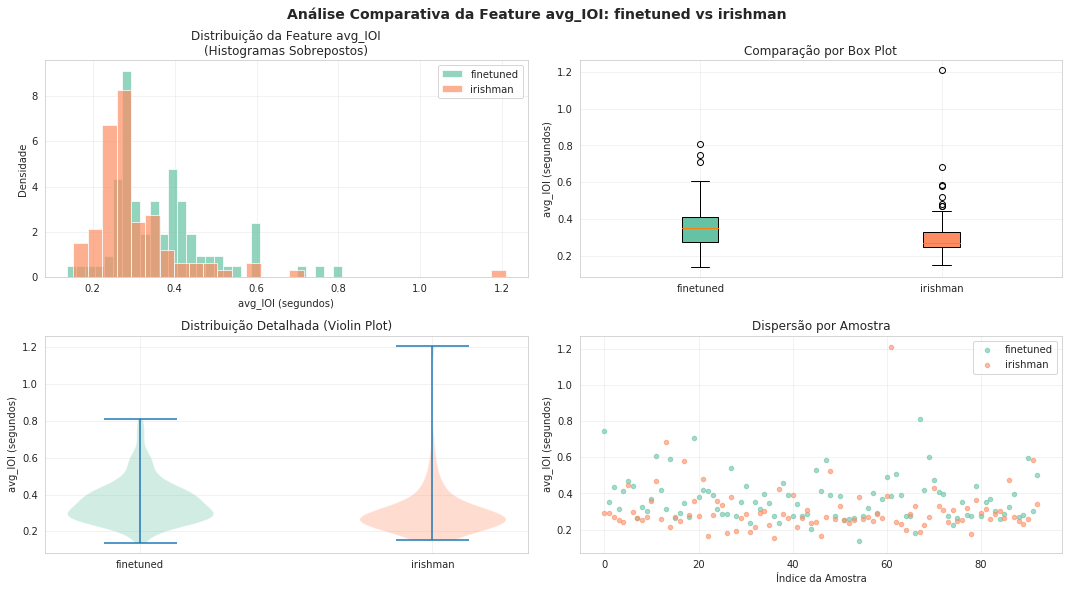


=== Interpretação das Distribuições ===
Coeficiente de Variação (finetuned)  : 0.328
Coeficiente de Variação (irishman): 0.431

Um coeficiente menor indica maior consistência rítmica.


In [27]:
# Visualização 1: Histogramas Comparativos da Feature avg_IOI
colors = ['#66c2a5', '#fc8d62']  # MODEL_1, MODEL_2

plt.figure(figsize=(15, 8))

# Subplot 1: Histogramas sobrepostos
plt.subplot(2, 2, 1)
plt.hist(set1_avg_ioi, bins=30, alpha=0.7, label=MODEL_1, color=colors[0], density=True)
plt.hist(set2_avg_ioi, bins=30, alpha=0.7, label=MODEL_2, color=colors[1], density=True)
plt.xlabel('avg_IOI (segundos)')
plt.ylabel('Densidade')
plt.title('Distribuição da Feature avg_IOI\n(Histogramas Sobrepostos)')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Box plots comparativos
plt.subplot(2, 2, 2)
data_for_boxplot = [set1_avg_ioi, set2_avg_ioi]
labels_for_boxplot = [MODEL_1, MODEL_2]
bp = plt.boxplot(data_for_boxplot, labels=labels_for_boxplot, patch_artist=True)
bp['boxes'][0].set_facecolor(colors[0])
bp['boxes'][1].set_facecolor(colors[1])
plt.ylabel('avg_IOI (segundos)')
plt.title('Comparação por Box Plot')
plt.grid(True, alpha=0.3)

# Subplot 3: Violin plots
plt.subplot(2, 2, 3)
parts = plt.violinplot([set1_avg_ioi, set2_avg_ioi], positions=[1, 2])
parts['bodies'][0].set_facecolor(colors[0])
parts['bodies'][1].set_facecolor(colors[1])
plt.xticks([1, 2], [MODEL_1, MODEL_2])
plt.ylabel('avg_IOI (segundos)')
plt.title('Distribuição Detalhada (Violin Plot)')
plt.grid(True, alpha=0.3)

# Subplot 4: Scatter plot comparativo (índices vs valores)
plt.subplot(2, 2, 4)
indices1 = range(len(set1_avg_ioi))
indices2 = range(len(set2_avg_ioi))
plt.scatter(indices1, set1_avg_ioi, alpha=0.6, label=MODEL_1, color=colors[0], s=20)
plt.scatter(indices2, set2_avg_ioi, alpha=0.6, label=MODEL_2, color=colors[1], s=20)
plt.xlabel('Índice da Amostra')
plt.ylabel('avg_IOI (segundos)')
plt.title('Dispersão por Amostra')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Análise Comparativa da Feature avg_IOI: {} vs {}'.format(MODEL_1, MODEL_2), 
             y=1.02, fontsize=14, fontweight='bold')
plt.show()

# Estatísticas adicionais para interpretação
print("\n=== Interpretação das Distribuições ===")
print("Coeficiente de Variação ({})  : {:.3f}".format(MODEL_1, np.std(set1_avg_ioi)/np.mean(set1_avg_ioi)))
print("Coeficiente de Variação ({}): {:.3f}".format(MODEL_2, np.std(set2_avg_ioi)/np.mean(set2_avg_ioi)))
print("\nUm coeficiente menor indica maior consistência rítmica.")

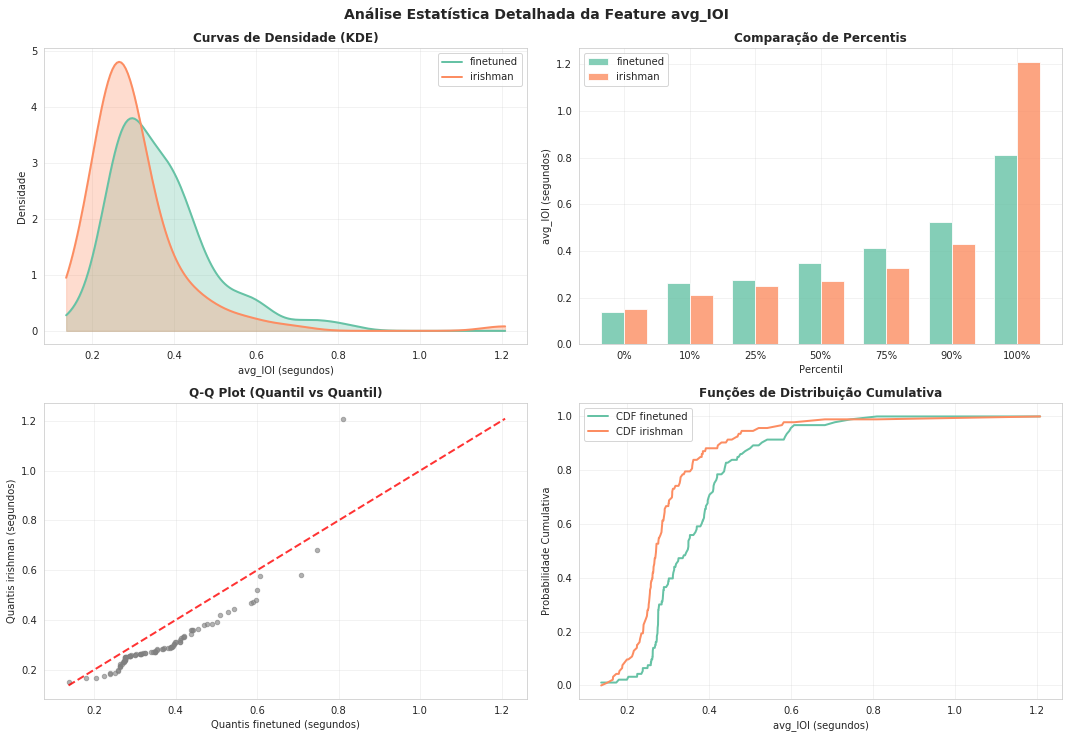

In [32]:
# Visualização 2: Análise de Densidade e Comparação Detalhada
colors = ['#66c2a5', '#fc8d62']  # MODEL_1, MODEL_2

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Gráfico 1: Curvas de densidade (KDE)
axes[0, 0].set_title('Curvas de Densidade (KDE)', fontweight='bold')
try:
    from scipy import stats
    
    # Criar range para o KDE
    all_values = np.concatenate([set1_avg_ioi, set2_avg_ioi])
    x_range = np.linspace(all_values.min(), all_values.max(), 200)
    
    # KDE para set1
    kde1 = stats.gaussian_kde(set1_avg_ioi)
    density1 = kde1(x_range)
    axes[0, 0].plot(x_range, density1, label=MODEL_1, color=colors[0], linewidth=2)
    
    # KDE para set2
    kde2 = stats.gaussian_kde(set2_avg_ioi)
    density2 = kde2(x_range)
    axes[0, 0].plot(x_range, density2, label=MODEL_2, color=colors[1], linewidth=2)
    
    axes[0, 0].fill_between(x_range, density1, alpha=0.3, color=colors[0])
    axes[0, 0].fill_between(x_range, density2, alpha=0.3, color=colors[1])
    
except ImportError:
    # Fallback se scipy não estiver disponível
    axes[0, 0].hist(set1_avg_ioi, bins=30, alpha=0.5, label=MODEL_1, density=True, color=colors[0])
    axes[0, 0].hist(set2_avg_ioi, bins=30, alpha=0.5, label=MODEL_2, density=True, color=colors[1])

axes[0, 0].set_xlabel('avg_IOI (segundos)')
axes[0, 0].set_ylabel('Densidade')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Gráfico 2: Comparação de percentis
axes[0, 1].set_title('Comparação de Percentis', fontweight='bold')
percentis = [0, 10, 25, 50, 75, 90, 100]
values1 = [np.percentile(set1_avg_ioi, p) for p in percentis]
values2 = [np.percentile(set2_avg_ioi, p) for p in percentis]

x_pos = np.arange(len(percentis))
width = 0.35
axes[0, 1].bar(x_pos - width/2, values1, width, label=MODEL_1, color=colors[0], alpha=0.8)
axes[0, 1].bar(x_pos + width/2, values2, width, label=MODEL_2, color=colors[1], alpha=0.8)
axes[0, 1].set_xlabel('Percentil')
axes[0, 1].set_ylabel('avg_IOI (segundos)')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(['{}%'.format(p) for p in percentis])
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Gráfico 3: Q-Q Plot (comparação de distribuições)
axes[1, 0].set_title('Q-Q Plot (Quantil vs Quantil)', fontweight='bold')
# Ordenar os dados
sorted1 = np.sort(set1_avg_ioi)
sorted2 = np.sort(set2_avg_ioi)

# Interpolar para ter o mesmo número de pontos
min_len = min(len(sorted1), len(sorted2))
if len(sorted1) > min_len:
    indices1 = np.linspace(0, len(sorted1)-1, min_len).astype(int)
    sorted1 = sorted1[indices1]
if len(sorted2) > min_len:
    indices2 = np.linspace(0, len(sorted2)-1, min_len).astype(int)
    sorted2 = sorted2[indices2]

axes[1, 0].scatter(sorted1, sorted2, alpha=0.6, s=20, color='gray')
# Linha de referência (y=x)
min_val = min(sorted1.min(), sorted2.min())
max_val = max(sorted1.max(), sorted2.max())
axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2)
axes[1, 0].set_xlabel('Quantis {} (segundos)'.format(MODEL_1))
axes[1, 0].set_ylabel('Quantis {} (segundos)'.format(MODEL_2))
axes[1, 0].grid(True, alpha=0.3)

# Gráfico 4: Diferença cumulativa
axes[1, 1].set_title('Funções de Distribuição Cumulativa', fontweight='bold')
# CDF empírica
sorted_all = np.sort(np.concatenate([set1_avg_ioi, set2_avg_ioi]))
cdf1 = np.searchsorted(np.sort(set1_avg_ioi), sorted_all, side='right') / float(len(set1_avg_ioi))
cdf2 = np.searchsorted(np.sort(set2_avg_ioi), sorted_all, side='right') / float(len(set2_avg_ioi))

axes[1, 1].plot(sorted_all, cdf1, label='CDF {}'.format(MODEL_1), color=colors[0], linewidth=2)
axes[1, 1].plot(sorted_all, cdf2, label='CDF {}'.format(MODEL_2), color=colors[1], linewidth=2)
axes[1, 1].set_xlabel('avg_IOI (segundos)')
axes[1, 1].set_ylabel('Probabilidade Cumulativa')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Análise Estatística Detalhada da Feature avg_IOI', y=1.02, fontsize=14, fontweight='bold')
plt.show()

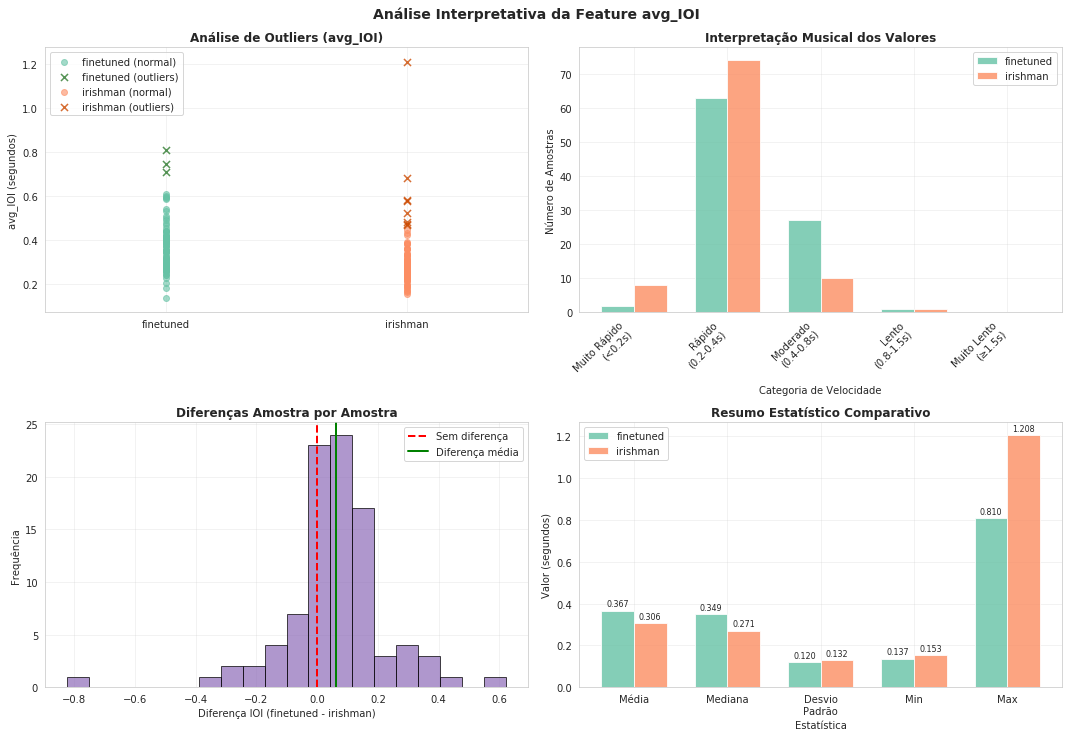


RELATÓRIO DE ANÁLISE - FEATURE avg_IOI

OUTLIERS IDENTIFICADOS:
  finetuned: 3 outliers de 93 amostras (3.0%)
  irishman: 8 outliers de 93 amostras (8.0%)

CATEGORIZAÇÃO MUSICAL:
  Muito Rápido (<0.2s): 2 vs 8 (2.0% vs 8.0%)
  Rápido (0.2-0.4s): 63 vs 74 (67.0% vs 79.0%)
  Moderado (0.4-0.8s): 27 vs 10 (29.0% vs 10.0%)
  Lento (0.8-1.5s): 1 vs 1 (1.0% vs 1.0%)
  Muito Lento (≥1.5s): 0 vs 0 (0.0% vs 0.0%)

DIFERENÇAS ENTRE MODELOS:
  Diferença média: 0.0608 segundos
  Amostras onde finetuned > irishman: 75.0%



In [31]:
# Visualização 3: Análise de Outliers e Interpretação Musical
colors = ['#66c2a5', '#fc8d62']  # MODEL_1, MODEL_2

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Gráfico 1: Identificação de outliers
axes[0, 0].set_title('Análise de Outliers (avg_IOI)', fontweight='bold')

# Calcular quartis e IQR para identificar outliers
def identify_outliers(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers, lower_bound, upper_bound

outliers1, lb1, ub1 = identify_outliers(set1_avg_ioi)
outliers2, lb2, ub2 = identify_outliers(set2_avg_ioi)

# Plot dos dados normais e outliers
normal1 = set1_avg_ioi[(set1_avg_ioi >= lb1) & (set1_avg_ioi <= ub1)]
normal2 = set2_avg_ioi[(set2_avg_ioi >= lb2) & (set2_avg_ioi <= ub2)]

axes[0, 0].scatter(np.ones(len(normal1)), normal1, alpha=0.6, color=colors[0], label='{} (normal)'.format(MODEL_1))
axes[0, 0].scatter(np.ones(len(outliers1)), outliers1, alpha=0.8, color='#2d7a2d', marker='x', s=50, label='{} (outliers)'.format(MODEL_1))
axes[0, 0].scatter(2*np.ones(len(normal2)), normal2, alpha=0.6, color=colors[1], label='{} (normal)'.format(MODEL_2))
axes[0, 0].scatter(2*np.ones(len(outliers2)), outliers2, alpha=0.8, color='#cc4a00', marker='x', s=50, label='{} (outliers)'.format(MODEL_2))

axes[0, 0].set_xlim(0.5, 2.5)
axes[0, 0].set_xticks([1, 2])
axes[0, 0].set_xticklabels([MODEL_1, MODEL_2])
axes[0, 0].set_ylabel('avg_IOI (segundos)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Gráfico 2: Categorização musical dos valores
axes[0, 1].set_title('Interpretação Musical dos Valores', fontweight='bold')

# Definir categorias baseadas nos valores típicos de IOI
def categorize_tempo(ioi_values):
    # Categorias baseadas em intervalos típicos de música
    very_fast = (ioi_values < 0.2).sum()      # < 0.2s (muito rápido)
    fast = ((ioi_values >= 0.2) & (ioi_values < 0.4)).sum()       # 0.2-0.4s (rápido)
    moderate = ((ioi_values >= 0.4) & (ioi_values < 0.8)).sum()   # 0.4-0.8s (moderado)
    slow = ((ioi_values >= 0.8) & (ioi_values < 1.5)).sum()       # 0.8-1.5s (lento)
    very_slow = (ioi_values >= 1.5).sum()     # >= 1.5s (muito lento)
    
    return [very_fast, fast, moderate, slow, very_slow]

categories = ['Muito Rápido\n(<0.2s)', 'Rápido\n(0.2-0.4s)', 'Moderado\n(0.4-0.8s)', 'Lento\n(0.8-1.5s)', 'Muito Lento\n(≥1.5s)']
counts1 = categorize_tempo(set1_avg_ioi)
counts2 = categorize_tempo(set2_avg_ioi)

x_pos = np.arange(len(categories))
width = 0.35
axes[0, 1].bar(x_pos - width/2, counts1, width, label=MODEL_1, color=colors[0], alpha=0.8)
axes[0, 1].bar(x_pos + width/2, counts2, width, label=MODEL_2, color=colors[1], alpha=0.8)
axes[0, 1].set_xlabel('Categoria de Velocidade')
axes[0, 1].set_ylabel('Número de Amostras')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(categories, rotation=45, ha='right')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Gráfico 3: Comparação direta (diferenças)
axes[1, 0].set_title('Diferenças Amostra por Amostra', fontweight='bold')
min_samples = min(len(set1_avg_ioi), len(set2_avg_ioi))
if min_samples > 0:
    differences = set1_avg_ioi[:min_samples] - set2_avg_ioi[:min_samples]
    axes[1, 0].hist(differences, bins=20, alpha=0.7, color='#8d6bb8', edgecolor='black')
    axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Sem diferença')
    axes[1, 0].axvline(x=np.mean(differences), color='green', linestyle='-', linewidth=2, label='Diferença média')
    axes[1, 0].set_xlabel('Diferença IOI ({} - {})'.format(MODEL_1, MODEL_2))
    axes[1, 0].set_ylabel('Frequência')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
else:
    axes[1, 0].text(0.5, 0.5, 'Não há amostras suficientes\npara comparação direta', 
                    ha='center', va='center', transform=axes[1, 0].transAxes)

# Gráfico 4: Resumo estatístico visual
axes[1, 1].set_title('Resumo Estatístico Comparativo', fontweight='bold')
stats_labels = ['Média', 'Mediana', 'Desvio\nPadrão', 'Min', 'Max']
stats1 = [np.mean(set1_avg_ioi), np.median(set1_avg_ioi), np.std(set1_avg_ioi), 
          np.min(set1_avg_ioi), np.max(set1_avg_ioi)]
stats2 = [np.mean(set2_avg_ioi), np.median(set2_avg_ioi), np.std(set2_avg_ioi), 
          np.min(set2_avg_ioi), np.max(set2_avg_ioi)]

x_pos = np.arange(len(stats_labels))
width = 0.35
bars1 = axes[1, 1].bar(x_pos - width/2, stats1, width, label=MODEL_1, color=colors[0], alpha=0.8)
bars2 = axes[1, 1].bar(x_pos + width/2, stats2, width, label=MODEL_2, color=colors[1], alpha=0.8)

# Adicionar valores nas barras
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    axes[1, 1].text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + 0.01,
                    '{:.3f}'.format(stats1[i]), ha='center', va='bottom', fontsize=8)
    axes[1, 1].text(bar2.get_x() + bar2.get_width()/2, bar2.get_height() + 0.01,
                    '{:.3f}'.format(stats2[i]), ha='center', va='bottom', fontsize=8)

axes[1, 1].set_xlabel('Estatística')
axes[1, 1].set_ylabel('Valor (segundos)')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(stats_labels)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Análise Interpretativa da Feature avg_IOI', y=1.02, fontsize=14, fontweight='bold')
plt.show()

# Relatório resumido
print("\n" + "="*60)
print("RELATÓRIO DE ANÁLISE - FEATURE avg_IOI")
print("="*60)
print("\nOUTLIERS IDENTIFICADOS:")
print("  {}: {} outliers de {} amostras ({:.1f}%)".format(MODEL_1, len(outliers1), len(set1_avg_ioi), 100*len(outliers1)/len(set1_avg_ioi)))
print("  {}: {} outliers de {} amostras ({:.1f}%)".format(MODEL_2, len(outliers2), len(set2_avg_ioi), 100*len(outliers2)/len(set2_avg_ioi)))

print("\nCATEGORIZAÇÃO MUSICAL:")
for i, cat in enumerate(categories):
    print("  {}: {} vs {} ({:.1f}% vs {:.1f}%)".format(
        cat.replace('\n', ' '), counts1[i], counts2[i], 
        100*counts1[i]/len(set1_avg_ioi), 100*counts2[i]/len(set2_avg_ioi)))

if min_samples > 0:
    print("\nDIFERENÇAS ENTRE MODELOS:")
    print("  Diferença média: {:.4f} segundos".format(np.mean(differences)))
    print("  Amostras onde {} > {}: {:.1f}%".format(MODEL_1, MODEL_2, 100*np.sum(differences > 0)/len(differences)))
    
print("\n" + "="*60)

## Interpretação e Conclusões da Análise avg_IOI

### O que as visualizações mostram:

1. **Distribuição Geral**: Os histogramas e curvas de densidade revelam como cada modelo distribui os intervalos entre notas
2. **Variabilidade**: Box plots e violin plots mostram a dispersão e presença de valores extremos
3. **Outliers**: Identificação de composições com características rítmicas incomuns
4. **Categorização Musical**: Classificação das composições em termos de velocidade/densidade
5. **Comparação Direta**: Diferenças sistemáticas entre os modelos

### Significado Musical:

- **avg_IOI baixo** (< 0.4s): Música mais densa, rápida, possivelmente virtuosística
- **avg_IOI médio** (0.4-0.8s): Música de andamento moderado, típica de muitos gêneros
- **avg_IOI alto** (> 0.8s): Música mais espaçada, contemplativa ou minimalista

### Implicações para Avaliação de Modelos:

- **Consistência**: Menor variabilidade pode indicar maior controle do modelo
- **Naturalidade**: Distribuição similar à música real sugere melhor qualidade
- **Diversidade**: Capacidade de gerar diferentes estilos de densidade temporal

Esta análise da feature `avg_IOI` complementa outras métricas para uma avaliação completa da qualidade musical dos modelos gerativos.